# import libraries

In [ ]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_log_error

# import shap
import optuna
# import category_encoders as ce

import xgboost as xgb
# import catboost as cat
# import lightgbm as lgb

from tqdm.notebook import tqdm

# get data

In [ ]:
!unzip -q "/content/drive/MyDrive/workation_price_prediction/Participant_Data_WPPH.zip"

In [ ]:
raw_train = pd.read_csv('/content/Participant_Data_WPPH/Train.csv')
raw_test = pd.read_csv('/content/Participant_Data_WPPH/Test.csv')
raw_sub = pd.read_csv('/content/Participant_Data_WPPH/sample submission.csv')

In [ ]:
# raw_train.to_excel('/content/drive/MyDrive/workation_price_prediction/train.xlsx', index=False)
# raw_test.to_excel('/content/drive/MyDrive/workation_price_prediction/test.xlsx', index=False)

In [ ]:
raw_train.sample(5)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
2817,0f09957bf2b9e2fe9050a1aa15913f4a,Awesome Shimla and Manali from Chandigarh,Premium,Shimla|Manali,3N Shimla . 3N Manali,Shimla|Manali,12-02-2021,Not Available,New Delhi,Not Available,0,5,Pinjore Gardens | Mall road | Kufri | Shimla ...,Cancellation any time after making the 1st pay...,23336.0
10044,7642c04ec5e2bb21e38059dc354fd61f,Munnar Getaway,Deluxe,Munnar,2N Munnar,Munnar,23-08-2021,Tea Village-MMT Holidays Special:,Mumbai,IndiGo,1,3,Tata Tea Museum | Eravikulam national park | ...,Cancellation any time after making the 1st pay...,7924.5
14687,ffbce649a945ede8d17bb1c908621c57,Beautiful North East with Cherrapunjee,Luxury,Guwahati|Cherrapunjee|Shillong,1N Guwahati . 2N Cherrapunjee . 2N Shillong,Guwahati|Cherrapunjee|Shillong,22-08-2021,Kiranshree Grand:4.5|Polo Orchid Resort:4.3|M ...,New Delhi,IndiGo|IndiGo,0,4,Kamakhya Temple | Shrimanta Shankardeva Kalak...,Cancellation any time after making the 1st pay...,24965.0
942,0fe5de92d3d83f4c6026d16cd42f0c54,Sri Lanka - Yala Special Weekend,Deluxe,Yala|Colombo,2N Yala . 2N Colombo,Yala|Colombo,01-03-2021,Chaarya Resort & Spa by Chandrika:4.0|Mount La...,New Delhi,IndiGo|IndiGo|IndiGo|IndiGo,1,3,Yala National Park | Yala Safari | Viharamaha...,Cancellation any time after making the 1st pay...,28915.0
16402,c1aa845082f3055c3baeb7ad64f3f202,Magical Kashmir Holiday,Luxury,Srinagar|Pahalgam|Srinagar|Gulmarg,1N Srinagar . 1N Pahalgam . 1N Srinagar . 1N G...,Srinagar|Pahalgam|Srinagar|Gulmarg,17-02-2021,Radisson Srinagar:3.9|WelcomHotel Pine N Peak ...,Mumbai,Spicejet|Spicejet,0,4,Dal Lake | Pahalgam | Avantipura Ruins | Beta...,Cancellation any time after making the 1st pay...,25695.5


# eda

In [ ]:
airlines = joblib.load('/content/drive/MyDrive/workation_price_prediction/airline_cleaned')

In [ ]:
airlines.shape

(30000,)

In [ ]:
eda = raw_train.copy()
test_eda = raw_test.copy()

In [ ]:
eda['is_foreign'] = eda['Places Covered'].apply(lambda x: int(any(c in foreign for c in x.split('|'))))

In [ ]:
mask = eda['is_foreign'] == 1
eda.loc[mask, 'Airline'].value_counts()[:20]

IndiGo|IndiGo|IndiGo|IndiGo                                                    453
Not Available                                                                  348
IndiGo|IndiGo                                                                  159
Malindo Air|Malindo Air|Malindo Air|Malindo Air                                139
Go Air|Go Air                                                                  127
Malaysia Airlines|Malaysia Airlines|Malaysia Airlines|Malaysia Airlines        124
Air India|Air India|Air India|Air India                                         89
Spicejet|Spicejet                                                               66
Air India Express|Air India Express                                             61
Srilankan Airlines|Srilankan Airlines                                           55
Srilankan Airlines|Srilankan Airlines|Srilankan Airlines|Srilankan Airlines     52
IndiGo|IndiGo|IndiGo                                                            51
Spic

In [ ]:
eda['Airline'].value_counts()

Not Available                                                        4910
IndiGo                                                               3687
Spicejet                                                             3084
Go Air                                                               2141
IndiGo|IndiGo                                                        1117
                                                                     ... 
Malindo Air|Srilankan Airlines|Srilankan Airlines                       1
Go Air|Go Air|Go Air                                                    1
Malindo Air|Malaysia Airlines|Go Air                                    1
Malindo Air|Malindo Air|Scoot|Malaysia Airlines|Malaysia Airlines       1
Malindo Air|Malindo Air|Scoot|Scoot|Malindo Air                         1
Name: Airline, Length: 314, dtype: int64

In [ ]:
eda['places_list'] = eda['Places Covered'].apply(lambda x: x.split('|'))
eda['no_of_places'] = eda['places_list'].apply(len)

In [ ]:
eda.groupby('no_of_places').agg(['mean', 'count'])['Per Person Price']

,mean,count
no_of_places,,
1,15491.306452,5363
2,18394.195986,5332
3,21843.033423,5565
4,23498.121023,3363
5,28018.776454,1049
6,28593.305085,177
7,31559.764706,102
8,35279.791667,12
9,37108.564516,31


In [ ]:
eda['places_list'].str.split()

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
20995   NaN
20996   NaN
20997   NaN
20998   NaN
20999   NaN
Name: places_list, Length: 21000, dtype: float64

In [ ]:
test_eda['places_list'] = test_eda['Places Covered'].apply(lambda x: x.split('|'))
test_eda['no_of_places'] = test_eda['places_list'].apply(len)

In [ ]:
test_eda.groupby('no_of_places').count()['Uniq Id']

no_of_places
1     2305
2     2302
3     2408
4     1382
5      473
6       64
7       50
8        2
9       11
11       3
Name: Uniq Id, dtype: int64

In [ ]:
cities_df = pd.read_csv('/content/drive/MyDrive/workation_price_prediction/cities.csv', usecols=['Cities', 'is_foriegn', 'country'])
cities_df.head()

,Cities,is_foriegn,country
0,Abu Dhabi,1,uae
1,Agra,0,india
2,Ahmedabad,0,india
3,Ahmednagar,0,india
4,Ajmer,0,india


In [ ]:
cities_df.country.value_counts()

india             128
sri lanka           9
indonesia           6
malaysia            5
new zealand         5
bhutan              4
australia           4
uae                 4
thailand            3
seychelles          2
singapore           2
russia              2
finland             1
england             1
czech republic      1
france              1
norway              1
mauritius           1
hong kong           1
denmark             1
Name: country, dtype: int64

In [ ]:
def get_country(x):
    cities = x.split('|')
    countries = set()
    for c in cities:
        mask = cities_df['Cities'] == c
        country = cities_df.loc[mask, 'country']
        # print(country.values[0])
        countries.add(country.values[0])
        # print(len(countries))
    return len(countries)
    # print(len(countries))

In [ ]:
eda['no_of_country'] = eda['Places Covered'].apply(lambda x: get_country(x))

In [ ]:
eda.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,no_of_country
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,1
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,1
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,1
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,1
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,1


In [ ]:
mask = eda['no_of_country'] == 3
eda.loc[mask]

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,no_of_country
1090,70bb246f67a3e4d28f0f10dd4307f1ed,Exquisite Sri Lanka,Deluxe,Anuradhapura|Sigiriya|Kandy|Nuwara Eliya|Yala|...,1N Anuradhapura . 1N Sigiriya . 1N Kandy . 1N ...,Anuradhapura|Sigiriya|Kandy|Nuwara Eliya|Yala|...,17-03-2021,Hotel Alakamanda:4.0|Aliya Resort and Spa:4.5|...,New Delhi,Spicejet|Spicejet|Spicejet|Spicejet,1,3,Thuparama | Ruwanweliseya | Abhayagiri Monast...,Cancellation any time after making the 1st pay...,33367.0,3
1773,247d2826149925889fdaac738294cc2c,Long Break to Sri Lanka,Deluxe,Negombo|Anuradhapura|Sigiriya|Kandy|Nuwara Eli...,1N Negombo . 1N Anuradhapura . 1N Sigiriya . 1...,Negombo|Anuradhapura|Sigiriya|Kandy|Nuwara Eli...,14-07-2021,Club Hotel Dolphin:4.5|City Resort:4.0|Aliya R...,New Delhi,IndiGo|IndiGo|IndiGo|IndiGo,1,3,Dutch Fort | Sigiriya Rock Fortress | Dambull...,Cancellation any time after making the 1st pay...,38930.0,3
3377,27392838d0dd76b77563bedf1c538b82,Long Break to Sri Lanka,Standard,Negombo|Anuradhapura|Sigiriya|Kandy|Nuwara Eli...,1N Negombo . 1N Anuradhapura . 1N Sigiriya . 1...,Negombo|Anuradhapura|Sigiriya|Kandy|Nuwara Eli...,16-02-2021,Camelot Beach Hotel:4.0|Hotel Alakamanda:4.0|R...,New Delhi,Srilankan Airlines|Srilankan Airlines,2,3,Dutch Fort | Sigiriya Rock Fortress | Dambull...,Cancellation any time after making the 1st pay...,37892.5,3
3580,e06ff90d5a4e2d285fa33af02d8ba930,Exquisite Sri Lanka,Standard,Anuradhapura|Sigiriya|Kandy|Nuwara Eliya|Yala|...,1N Anuradhapura . 1N Sigiriya . 1N Kandy . 1N ...,Anuradhapura|Sigiriya|Kandy|Nuwara Eliya|Yala|...,11-12-2021,Hotel Alakamanda:4.0|RHO Sigiriya Lake Edge Re...,New Delhi,Air India|Air India|Air India|Air India,2,3,Thuparama | Ruwanweliseya | Abhayagiri Monast...,Cancellation any time after making the 1st pay...,33839.5,3
4129,650ef9ebdae165fc88c0a6a44b22eb3b,Exquisite Sri Lanka,Standard,Anuradhapura|Sigiriya|Kandy|Nuwara Eliya|Yala|...,1N Anuradhapura . 1N Sigiriya . 1N Kandy . 1N ...,Anuradhapura|Sigiriya|Kandy|Nuwara Eliya|Yala|...,15-03-2021,Hotel Alakamanda:4.0|RHO Sigiriya Lake Edge Re...,Mumbai,IndiGo|IndiGo|IndiGo|IndiGo,2,3,Thuparama | Ruwanweliseya | Abhayagiri Monast...,Cancellation any time after making the 1st pay...,34393.0,3
4264,60347b7ab2a8f1e490e7dfc411ffa992,Magical Sri Lanka,Standard,Anuradhapura|Trincomalee|Sigiriya|Kandy|Nuwara...,1N Anuradhapura . 1N Trincomalee . 1N Sigiriya...,Anuradhapura|Trincomalee|Sigiriya|Kandy|Nuwara...,19-08-2021,Hotel Alakamanda:4.0|Anantamaa:4.0|RHO Sigiriy...,New Delhi,IndiGo|IndiGo|IndiGo|IndiGo,2,3,Ruwanweliseya | Abhayagiri Monastery Complex ...,Cancellation any time after making the 1st pay...,36111.0,3
4304,14c17833ba53f51604399ce3035e539c,"Ultimate Bali, Singapore & Kuala Lumpur (10N)",Deluxe,Bali|Singapore|Kuala Lumpur,5N Bali . 3N Singapore . 2N Kuala Lumpur,Bali|Singapore|Kuala Lumpur,14-11-2021,Kuta Central Park Hotel - MMT Special:4.0|PARK...,New Delhi,Malindo Air|Malindo Air|AirAsia Indonesia|Scoo...,1,3,Not Available,Cancellation any time after making the 1st pay...,58671.5,3
4505,c1c6b3122215ded17979f5d1232db587,"Ultimate Bali, Singapore & Kuala Lumpur (10N)",Deluxe,Bali|Singapore|Kuala Lumpur,5N Bali . 3N Singapore . 2N Kuala Lumpur,Bali|Singapore|Kuala Lumpur,27-04-2021,Kuta Central Park Hotel - MMT Special:4.0|MERC...,Mumbai,Malindo Air|Malindo Air|Malindo Air|Malindo Ai...,1,3,Not Available,Cancellation any time after making the 1st pay...,39327.5,3
4773,e7837f671255a240a0912cf3e8d1bbac,"Ultimate Bali, Singapore & Kuala Lumpur (10N)",Deluxe,Bali|Singapore|Kuala Lumpur,5N Bali . 3N Singapore . 2N Kuala Lumpur,Bali|Singapore|Kuala Lumpur,06-07-2021,Kuta Central Park Hotel - MMT Special:4.0|Hote...,New Delhi,Malindo Air|Malindo Air|Scoot|Scoot|Malaysia A...,1,3,Not Available,Cancellation any time after making the 1st pay...,53223.0,3
5175,908bc0ad25a26fa

In [ ]:
eda['no_of_country'].value_counts()

1    20261
2      700
3       39
Name: no_of_country, dtype: int64

In [ ]:
eda.groupby('no_of_country').agg(['count', 'mean'])['Per Person Price']

,count,mean
no_of_country,,
1,20261,19417.366986
2,700,37219.703571
3,39,45560.846154


In [ ]:
pd.concat([eda, test_eda], axis=1).head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,places_list,no_of_places,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,places_list,no_of_places
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,"[New Delhi, Shimla, Manali, Chandigarh]",4,12c47aefbcca65d6156ba0bc7946704b,Goa 5N stay with flights & Transfers-North Goa,Luxury,Goa,5N Goa,Goa,13-07-2021,Novotel Goa Resort & Spa:4.1,New Delhi,IndiGo,0.0,4.0,Not Available,Cancellation any time after making the 1st pay...,[Goa],1.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,"[Srinagar, Pahalgam, Srinagar]",3,156febf7d27315ae9f210ed13bca3ac2,Into the Wild - Weekend at Bandipur National Park,Luxury,Bandipur,2N Bandipur,Bandipur,20-03-2021,The Windflower Jungle Resorts & Spa Bandipur:4.4,New Delhi,Not Available,0.0,4.0,Bandipur National Park,This cancellation policy is applicable for boo...,[Bandipur],1.0
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,"[Udaipur, Chittorgarh]",2,a7f43314e3ee6464a4e35b874bddf2ea,Unforgettable Munnar Getaway - Private Picnic ...,Standard,Munnar,3N Munnar,Munnar,09-02-2022,Not Available,New Delhi,Not Available,2.0,3.0,Old Munnar Town | Eravikulam national park | ...,This cancellation policy is applicable for boo...,[Munnar],1.0
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,"[Munnar, Kumarakom, Allepey, Kovalam and Poovar]",4,d9cc4b407f3d5d290560c03d9ac71035,Munnar for Adventure Lovers - Top Valley Trek,Deluxe,Munnar,3N Munnar,Munnar,16-05-2021,Not Available,Mumbai,Not Available,1.0,3.0,Tata Tea Museum | Eravikulam national park | ...,This cancellation policy is applicable for boo...,[Munnar],1.0
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,"[Pattaya, Bangkok]",2,b3bbc8aa6429feb260e9ac0a91f252c4,Splendours of Kerala - Make your own Tea,Luxury,Cochin|Munnar|Thekkady|Allepey,1N Cochin . 2N Munnar . 1N Thekkady . 1N Allepey,Cochin|Munnar|Thekkady|Allepey,13-10-2021,Casino Hotel - Cgh Earth-MMT Holidays Special:...,New Delhi,IndiGo,0.0,4.0,Fort Cochin | Dutch Palace | Jewish Synagogue...,Cancellation any time after making the 1st pay...,"[Cochin, Munnar, Thekkady, Allepey]",4.0


In [ ]:
airline = []
for i in tqdm(range(len(df_places['Places Covered']))):
    temp = df.loc[df['Places Covered'] == df_places['Places Covered'][i]]
    ans = temp['Airline'].mode()
    print(np.array(ans))     
    if ans == 'Not Available':
        temp2 = df.loc[df['Package Name'] == temp['Package Name'].mode()[0]]
        ans = temp2['Airline'].mode()[0]
        print(temp['Package Name'].mode()[0],'||||||', ans)
        airline.append(ans)

In [ ]:
col = df_test.columns
vals = df[col].values
vals2 = df_test[col].values
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=3)
# for train set
knn_imputer.fit(vals)
x = knn_imputer.transform(vals)
# for test set
knn_imputer.fit(vals2)
x_test = knn_imputer.transform(vals2)
x = pd.DataFrame(data = x, columns = col)
x_test = pd.DataFrame(data = x_test, columns = col)
df = x
df_test = x_test

In [ ]:
dates = pd.to_datetime(eda['Travel Date'], dayfirst=True)
dates

0       2021-07-30
1       2021-08-12
2       2021-04-26
3       2021-08-27
4       2021-12-12
           ...    
20995   2021-04-15
20996   2021-08-30
20997   2021-02-27
20998   2022-01-13
20999   2021-05-30
Name: Travel Date, Length: 21000, dtype: datetime64[ns]

In [ ]:
from datetime import datetime
(dates - datetime(2020, 12, 31)).dt.days

0        211
1        224
2        116
3        239
4        346
        ... 
20995    105
20996    242
20997     58
20998    378
20999    150
Name: Travel Date, Length: 21000, dtype: int64

In [ ]:
# mask = eda['Package Name'] == 'Sai Baba Darshan from Mumbai'
mask = eda['Airline'] == 'Not Available'
eda.loc[mask][:10]

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,2021-07-30,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
7,07943295cfdce5cb20861e8369948b1d,Kasol & Manali holiday from Delhi,Deluxe,Kasol|Manali,2N Kasol . 3N Manali,Kasol|Manali,2021-10-12,The Himalayan Village:Four|The Holiday Resorts...,Mumbai,Not Available,1,3,Pandoh Dam | Hadimba Temple | Tibetan Monaste...,Cancellation any time after making the 1st pay...,14454.5
13,3429b7d0a59153d4208e1da2c6375fd6,Holiday in Udaipur & Mount Abu by Volvo from A...,Standard,Udaipur|Mount Abu,2N Udaipur . 1N Mount Abu,Udaipur|Mount Abu,2021-05-21,Not Available,New Delhi,Not Available,2,3,Lake Pichola | Jag Mandir Palace | Return Vol...,Cancellation any time after making the 1st pay...,6911.0
18,d26163e7ff27bf1e8637728c785df0db,A Relaxing Rendezvous in Himachal from Delhi,Luxury,Shimla|Manali|Dharamshala,2N Shimla . 3N Manali . 2N Dharamshala,Shimla|Manali|Dharamshala,2021-11-27,Not Available,Mumbai,Not Available,0,4,Kufri | Mall road | Viceregal Lodge | Pandoh ...,Cancellation any time after making the 1st pay...,20739.0
24,4a921ab444ed8941ac47ae2023f1f932,Goa 3 Nights - Pure Veg Special,Deluxe,Goa,3N Goa,Goa,2021-09-05,Sharanam Greens Resort:3,New Delhi,Not Available,1,3,Not Available,Cancellation any time after making the 1st pay...,2580.0
27,d8c2cf32f9feb23785e619306e565159,Gangtok Pelling & Darjeeling Holidays with Sha...,Premium,Gangtok|Pelling|Darjeeling,3N Gangtok . 1N Pelling . 2N Darjeeling,Gangtok|Pelling|Darjeeling,2021-04-13,Not Available,Mumbai,Not Available,0,5,Baba Mandir | Changu Lake | Rumtek Monastery ...,Cancellation any time after making the 1st pay...,13465.0
32,667806187e7ce471bbbde18af6998064,Take a Break in Shimla - Personal Photoshoot i...,Luxury,Shimla,3N Shimla,Shimla,2021-03-26,Not Available,Mumbai,Not Available,0,4,Shimla Church | Scandal point | Gaeity Theatr...,Not Available,22910.0
35,097ecbfe889be8266ac81a8aad061ac3,Holiday in Lovely Himachal from Delhi,Luxury,New Delhi|Shimla|Manali|Chandigarh,2N New Delhi . 2N Shimla . 3N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,2021-12-07,Not Available,New Delhi,Not Available,0,4,Rajghat | Jama Masjid | Red fort | Chandni Ch...,Cancellation any time after making the 1st pay...,24753.5
56,ccaa1f89da263261639d5f63b2b2a574,Escaping the City - In the Lap of Nature in Coorg,Standard,Coorg,3N Coorg,Coorg,2021-12-17,Not Available,New Delhi,Not Available,2,3,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,7311.5
57,30ee2d513cf4ce9f1baa7deccd3e576f,Young & Free - Short Stay in Goa - By Bus from...,Standard,Goa,2N Goa,Goa,2021-09-15,Santana Beach Resort:4.5,New Delhi,Not Available,2,3,Ahmedabad to Goa by Bus (Departure between 12...,This cancellation policy is applicable for boo...,5818.0


In [ ]:
eda['Travel Date'] = pd.to_datetime(eda['Travel Date'], dayfirst=True)

In [ ]:
eda.sort_values(by='Travel Date')

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
3393,349e0d65d7c0cd0ff250060d9df3d085,Scinitillating North East,Premium,Darjeeling|Pelling|Gangtok|Kalimpong,2N Darjeeling . 2N Pelling . 2N Gangtok . 1N K...,Darjeeling|Pelling|Gangtok|Kalimpong,2021-01-01,Ramada by Wyndham Darjeeling Gandhi Road:4.4|T...,Mumbai,IndiGo|IndiGo,0,5,Tiger Hill | Himalayan Mountaineering Institu...,Cancellation any time after making the 1st pay...,38311.0
18048,a0b099bcbc4e86c5505dc69464676d42,"Quick Getaway to Agra, the City of the Taj Mahal",Deluxe,Agra,1N Agra,Agra,2021-01-02,The Taj Vilas:4.1,New Delhi,Not Available,1,3,Not Available,This cancellation policy is applicable for boo...,2868.0
16084,a276e057af099a7062f1b1b92ff426ae,Splendid Kerala,Premium,Cochin|Allepey|Thekkady,1N Cochin . 1N Allepey . 2N Thekkady,Cochin|Allepey|Thekkady,2021-01-02,Casino Hotel - Cgh Earth-MMT Holidays Special:...,Mumbai,IndiGo,0,5,Dutch Palace | Jewish Synagogue | St. Francis...,Cancellation any time after making the 1st pay...,16424.5
3808,767f437c8c4e414aa3e46390eb141fe6,Beautiful North East - Cherrapunjee Special,Standard,Shillong|Cherrapunjee|Shillong,1N Shillong . 1N Cherrapunjee . 2N Shillong,Shillong|Cherrapunjee|Shillong,2021-01-02,Aura:2.6|OYO 37862 Mountain View Inn:2.4|Hotel...,New Delhi,IndiGo,2,3,Umiam Lake | Elephant Falls | Shillong Peak |...,Cancellation any time after making the 1st pay...,16519.5
3834,08ec94cd57fbe7558f36f0c852930149,A 3 Nights holiday to South,Premium,Ooty|Mysore,2N Ooty . 1N Mysore,Ooty|Mysore,2021-01-02,Hotel Meadows Residency:4.4|Country Inn And Su...,New Delhi,IndiGo|Spicejet,0,5,Doddabetta Peak | Ooty Botanical Gardens | Si...,Cancellation any time after making the 1st pay...,13814.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14161,64b88ec7e4dfa31bff3aa5bc7c64c7eb,Self Drive Trip - Relaxed Jaipur Getaway from ...,Luxury,Jaipur,3N Jaipur,Jaipur,2022-12-03,Not Available,Mumbai,Not Available,0,4,Self Drive SUV for 4 days from Delhi,This cancellation policy is applicable for boo...,10130.5
6321,f22e642f4a49ea94f6168697e89e130f,Sri Lanka Tour - 5 Cities Special,Standard,Sigiriya|Trincomalee|Kandy|Colombo|Negombo,1N Sigiriya . 1N Trincomalee . 1N Kandy . 1N C...,Sigiriya|Trincomalee|Kandy|Colombo|Negombo,2022-12-03,RHO Sigiriya Lake Edge Retreat:5.0|Anantamaa:4...,New Delhi,Srilankan Airlines|Srilankan Airlines,2,3,Sigiriya Rock Fortress | Dambulla Cave Temple...,Cancellation any time after making the 1st pay...,25449.5
8453,c3012f5ccfa4beb39e5cdceaf6fbf8b6,WOW Holiday in Shimla & Manali,Standard,Shimla|Manali,4N Shimla . 3N Manali,Shimla|Manali,2022-12-03,Not Available,New Delhi,Not Available,2,3,Kufri | Mall road | Shimla Church | Scandal p...,Cancellation any time after making the 1st pay...,12006.5
7783,3fd59af339120d37e1496c73108306f3,Experience Grandeur in Jewels of Rajasthan (4 ...,Luxury,Jaipur|Jodhpur,2N Jaipur . 2N Jodhpur,Jaipur|Jodhpur,2022-12-04,Not Available,Mumbai,Not Available,0,4,City Palace | Hawa Mahal | Jantar Mantar | Am...,Cancellation any time after making the 1st pay...,66049.5


In [ ]:
cities = pd.read_csv('/content/drive/MyDrive/workation_price_prediction/cities.csv')
cities.head()

,Cities,is_foriegn,country,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Abu Dhabi,1,uae,NaN,NaN,NaN
1,Agra,0,india,NaN,NaN,NaN
2,Ahmedabad,0,india,NaN,NaN,NaN
3,Ahmednagar,0,india,NaN,NaN,city
4,Ajmer,0,india,NaN,NaN,hill station


In [ ]:
cities.country.value_counts()

india             128
sri lanka           9
indonesia           6
malaysia            5
new zealand         5
australia           4
uae                 4
bhutan              4
thailand            3
singapore           2
russia              2
seychelles          2
norway              1
hong kong           1
finland             1
mauritius           1
france              1
denmark             1
czech republic      1
england             1
Name: country, dtype: int64

In [ ]:
mask = cities['is_foriegn'] == 1
foreign = set(cities.loc[mask, 'Cities'].values)
# foreign = set(foreign['Cities'].values)
foreign

{'Abu Dhabi',
 'Auckland',
 'Bali',
 'Bangkok',
 'Batam',
 'Bentota',
 'Bintan Island',
 'Cairns',
 'Christchurch',
 'Colombo',
 'Copenhagen',
 'Dambulla',
 'Dubai',
 'Franz Josef',
 'Galle',
 'Genting',
 'Gold Coast',
 'Helsinki',
 'Hong Kong',
 'Jakarta',
 'Johor Bahru',
 'Kandy',
 'Kuala Lumpur',
 'Kuta',
 'Langkawi',
 'Mahe Island',
 'Mauritius',
 'Melbourne',
 'Moscow',
 'Negombo',
 'Nuwara Eliya',
 'Oslo',
 'Paris',
 'Paro',
 'Pattaya',
 'Penang',
 'Phuentsholing',
 'Phuket',
 'Prague',
 'Praslin Island',
 'Punakha',
 'Queenstown',
 'Ras Al Khaimah',
 'Rotorua',
 'Saint Petersburg',
 'Seminyak',
 'Sharjah',
 'Sigiriya',
 'Singapore',
 'Singapore Cruise',
 'Sydney',
 'Thimpu',
 'Trincomalee',
 'Yala'}

In [ ]:
joblib.dump(foreign, '/content/drive/MyDrive/workation_price_prediction/foreign_cities')

['/content/drive/MyDrive/workation_price_prediction/foreign_cities']

In [ ]:
eda['is_f'] = eda['Places Covered'].apply(lambda x: int(any(c in foreign for c in x.split('|'))))

In [ ]:
eda[['Destination', 'is_f']]

,Destination,is_f
0,New Delhi|Shimla|Manali|Chandigarh,0
1,Srinagar|Pahalgam|Srinagar,0
2,Udaipur|Chittorgarh,0
3,Munnar|Kumarakom|Allepey|Kovalam and Poovar,0
4,Pattaya|Bangkok,1
...,...,...
20995,Shimla|Manali|New Delhi,0
20996,Srinagar|Gulmarg|Pahalgam|Srinagar,0
20997,Colombo,1
20998,Darjeeling|Pelling|Gangtok,0


In [ ]:
eda.groupby('is_f').mean()

,Flight Stops,Meals,Per Person Price
is_f,,,
0,0.845443,3.693534,18640.485863
1,1.053957,3.457634,30549.252798


In [ ]:
def is_f(x):

    for i, row in eda[['Destination']].iterrows():
        if any(c in foreign for c in row[0].split('|')):
            return 1
            
        return 0

Streaming output truncated to the last 5000 lines.
Name: 7983, dtype: object
Indian
Destination    Sigiriya|Trincomalee|Kandy|Colombo|Negombo
Name: 7984, dtype: object
Foreign
Destination    Haridwar|Rishikesh|Mussoorie
Name: 7985, dtype: object
Indian
Destination    Shimla|Manali|Dharamshala|Dalhousie|Chandigarh
Name: 7986, dtype: object
Indian
Destination    Coorg
Name: 7987, dtype: object
Indian
Destination    Colombo|Bentota
Name: 7988, dtype: object
Foreign
Destination    Shimla|Manali|Chandigarh
Name: 7989, dtype: object
Indian
Destination    Kovalam and Poovar|Kanyakumari
Name: 7990, dtype: object
Indian
Destination    Ajmer|Pushkar
Name: 7991, dtype: object
Indian
Destination    Manali|Chandigarh
Name: 7992, dtype: object
Indian
Destination    Munnar|Thekkady|Kumarakom
Name: 7993, dtype: object
Indian
Destination    Kasauli|Shimla
Name: 7994, dtype: object
Indian
Destination    Chennai|Mahabalipuram
Name: 7995, dtype: object
Indian
Destination    Jaipur|Pushkar
Name: 7996, dtyp

KeyboardInterrupt: ignored

In [ ]:
hotels = eda[['Hotel Details']]

In [ ]:
from collections import defaultdict

hotel_rating = defaultdict(list)
h_no = []
for i, row in tqdm(hotels.iterrows(), total=21000):
    if row[0] == 'Not Available':
        # print(row[0])
        continue
    h = row[0].split('|')
    # print(h)
    # print('************')
    for name_rat in h:
        name, *rat = name_rat.split(':')
        if rat[0]:
            hotel_rating[name].append(''.join(rat))
    #     print(rat)
    # print('************')
    # h_no.append((len(h)))

    # if i == 10:
    #     break

  0%|          | 0/21000 [00:00<?, ?it/s]

In [ ]:
for k, v in hotel_rating.items():
    # if k == 'The Lodhi A member of The Leading Hotels Of The World':
    print(k)
    print(max(v, key=lambda x: v.count(x)))
    

The Orchard Retreat & Spa
4.6
WelcomHotel Pine N Peak Pahalgam - Member ITC Hotel Group
4.1
The Ananta
4.4
juSTa Lake Nahargarh Palace
4
Elixir Hills Suites Resort & Spa-MMT Holidays Special
4.6
The Zuri Kumarakom, Kerala Resort & Spa
4.6
Marari Beach - CGH Earth
4.6
Dusit Thani Pattaya - MMT Special
4.5
Amari Watergate Hotel Bangkok - MMT Special
4.2
Ratnawali A Vegetarian Heritage Hotel
4.1
The Himalayan Village
4.6
The Holiday Resorts, Cottages & Spa
Four
California Group of Houseboats
3.6
The Rosewood Hotel
3.4
The Chinar Resort & Spa
4.6
Chunda Palace
4.7
UDAY SAMUDRA LEISURE BEACH HOTEL & SPA-MMT Holidays Special
4
Casino Hotel - Cgh Earth-MMT Holidays Special
4.5
Parakkat Nature Resorts
4.5
Kiranshree Grand
4.5
Hotel 6 Chandigarh Zirakpur(Medallion)
4
Summit Thistle Villa Resort & Spa
4.3
Snow Valley Resorts
4.4
Hotel Maya Regency Bhimtal
3.8
Heritage Resort
4.5
Corbett View Resort
3.8
Kodai Resort Hotel
4.1
Hotel Meadows Residency
4.4
Hotel Jem Valley
3.8
The Tamara Kodai
4.6
D

In [ ]:
mode_hotel_rating = { k: max(v, key=lambda x: v.count(x)) for k, v in hotel_rating.items() }
# mode_hotel_rating
# print(len(mode_hotel_rating))

In [ ]:
number_map = {
    'one': '1.0',
    'two': '2.0',
    'three': '3.0',
    'four': '4.0',
    'five': '5.0',
}

In [ ]:
values = []

for k, v in mode_hotel_rating.items():
    # print(v[0])
    if v[0].isalpha():
        print(k)
        print(v)
        mode_hotel_rating[k] = number_map.get(v.lower(), '5.0')
        values.append(v)

print(values)

The Holiday Resorts, Cottages & Spa
Four
Radisson Blu Plaza Delhi Airport
Five
Summit Hermon Hotel and Spa-MMT HOLIDAY SPECIAL
Four
The Terrace
Four
Best Western Kuta Beach-MMT Special
Three
Larisa Resort
Five
The Lodhi
A member of The Leading Hotels Of The WorldFive
Le Poshe by Sparsa
Five
Summit Namnang Courtyard & Spa, Gangtok-MMT Holidays Special
Three
Himalaya Darshan Resort
Three
Vimoksha Resorts
Three
Hotel Brijwasi Royal
Three
EllBee Ganga View
Four
Howard Johnson Bur Dubai
Three
The Marque Hotel Kuala Lumpur
Three
The Atrium on the Greens
Four
Hotel Wood Creek
Four
The Anvaya Beach Resort Bali - MMT Special
Five
Summit Barsana Resort & Spa-MMT HOLIDAY SPECIAL
Three
The LaLiT New Delhi
Five
Honeymoon Inn
Three
DoubleTree by Hilton Resort  & Spa Marjan Island
Five
Laguna Beach Hotel & Spa - MMT Special
Three
Treehouse Chail Villas
Four
Hotel Sandhya Palace
Three
Trident Agra
Five
Hotel Seven Roads Grand Inn
Three
Jain Group Sanderling Resort & spa
Four
Radisson Golf & Convention

In [ ]:
for k, v in mode_hotel_rating.items():
    # print(k, v)
    if v[0].isalpha():
        print(k)
        print(v)

In [ ]:
pn = eda[['Package Name']]
pn

,Package Name
0,Best of Shimla and Manali Holiday from Delhi
1,Kashmir Valley vacation
2,Might of Mewar- Udaipur and Chittorgarh
3,Colorful Kerala ( Romantic Getaway )
4,A Week In Bangkok & Pattaya
...,...
20995,Shimla & Manali Retreat from Delhi
20996,Bedazzling Kashmir Holiday
20997,A relaxing week in Colombo (Bentota and Galle ...
20998,Awesome North East with Pelling


In [ ]:
mode_hotel_rating['The Lodhi']

'5.0'

In [ ]:
len(mode_hotel_rating)

1264

In [ ]:
ratings = { k: float(v) for k, v in mode_hotel_rating.items() }
ratings

{'The Orchard Retreat & Spa': 4.6,
 'WelcomHotel Pine N Peak Pahalgam - Member ITC Hotel Group': 4.1,
 'The Ananta': 4.4,
 'juSTa Lake Nahargarh Palace': 4.0,
 'Elixir Hills Suites Resort & Spa-MMT Holidays Special': 4.6,
 'The Zuri Kumarakom, Kerala Resort & Spa': 4.6,
 'Marari Beach - CGH Earth': 4.6,
 'Dusit Thani Pattaya - MMT Special': 4.5,
 'Amari Watergate Hotel Bangkok - MMT Special': 4.2,
 'Ratnawali A Vegetarian Heritage Hotel': 4.1,
 'The Himalayan Village': 4.6,
 'The Holiday Resorts, Cottages & Spa': 4.0,
 'California Group of Houseboats': 3.6,
 'The Rosewood Hotel': 3.4,
 'The Chinar Resort & Spa': 4.6,
 'Chunda Palace': 4.7,
 'UDAY SAMUDRA LEISURE BEACH HOTEL & SPA-MMT Holidays Special': 4.0,
 'Casino Hotel - Cgh Earth-MMT Holidays Special': 4.5,
 'Parakkat Nature Resorts': 4.5,
 'Kiranshree Grand': 4.5,
 'Hotel 6 Chandigarh Zirakpur(Medallion)': 4.0,
 'Summit Thistle Villa Resort & Spa': 4.3,
 'Snow Valley Resorts': 4.4,
 'Hotel Maya Regency Bhimtal': 3.8,
 'Heritage Re

In [ ]:
import joblib

In [ ]:
joblib.dump(ratings, '/content/drive/MyDrive/workation_price_prediction/hotel_ratings')

['/content/drive/MyDrive/workation_price_prediction/hotel_ratings']

In [ ]:
joblib.load('test')

{'The Orchard Retreat & Spa': '4.6',
 'WelcomHotel Pine N Peak Pahalgam - Member ITC Hotel Group': '4.1',
 'The Ananta': '4.4',
 'juSTa Lake Nahargarh Palace': '4',
 'Elixir Hills Suites Resort & Spa-MMT Holidays Special': '4.6',
 'The Zuri Kumarakom, Kerala Resort & Spa': '4.6',
 'Marari Beach - CGH Earth': '4.6',
 'Dusit Thani Pattaya - MMT Special': '4.5',
 'Amari Watergate Hotel Bangkok - MMT Special': '4.2',
 'Ratnawali A Vegetarian Heritage Hotel': '4.1',
 'The Himalayan Village': '4.6',
 'The Holiday Resorts, Cottages & Spa': '4.0',
 'California Group of Houseboats': '3.6',
 'The Rosewood Hotel': '3.4',
 'The Chinar Resort & Spa': '4.6',
 'Chunda Palace': '4.7',
 'UDAY SAMUDRA LEISURE BEACH HOTEL & SPA-MMT Holidays Special': '4',
 'Casino Hotel - Cgh Earth-MMT Holidays Special': '4.5',
 'Parakkat Nature Resorts': '4.5',
 'Kiranshree Grand': '4.5',
 'Hotel 6 Chandigarh Zirakpur(Medallion)': '4',
 'Summit Thistle Villa Resort & Spa': '4.3',
 'Snow Valley Resorts': '4.4',
 'Hotel M

In [ ]:
pd.to_datetime(eda['Travel Date']).dt.year.value_counts()

2021    20148
2022      852
Name: Travel Date, dtype: int64

In [ ]:
eda.columns

Index(['Uniq Id', 'Package Name', 'Package Type', 'Destination', 'Itinerary',
       'Places Covered', 'Travel Date', 'Hotel Details', 'Start City',
       'Airline', 'Flight Stops', 'Meals', 'Sightseeing Places Covered',
       'Cancellation Rules', 'Per Person Price'],
      dtype='object')

In [ ]:
eda['Itinerary'].value_counts()

3N Goa                                              453
3N Munnar                                           223
2N Munnar . 1N Thekkady . 1N Allepey                219
1N Cochin . 2N Munnar . 1N Thekkady . 1N Allepey    194
1N Mysore . 2N Coorg . 2N Ooty                      193
                                                   ... 
1N Nuwara Eliya . 1N Bentota . 1N Colombo             1
1N Agra . 1N Gwalior . 1N Orchha . 2N Khajuraho       1
2N Singapore . 2N Singapore Cruise                    1
2N Leh . 1N Nubra Valley . 1N Leh                     1
3N Shillong . 2N Kaziranga . 1N Guwahati              1
Name: Itinerary, Length: 966, dtype: int64

In [ ]:
eda.loc[eda['Places Covered'] == eda['Destination']].shape

(21000, 15)

In [ ]:
eda.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0


In [ ]:
it = eda[['Itinerary']]

In [ ]:
it['list'] = it.Itinerary.str.split(' . ')
it

,Itinerary,list
0,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,"[1N New Delhi, 2N Shimla, 2N Manali, 1N Chandi..."
1,1N Srinagar . 2N Pahalgam . 1N Srinagar,"[1N Srinagar, 2N Pahalgam, 1N Srinagar]"
2,2N Udaipur . 1N Chittorgarh,"[2N Udaipur, 1N Chittorgarh]"
3,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,"[2N Munnar, 1N Kumarakom, 1N Allepey, 2N Koval..."
4,4N Pattaya . 3N Bangkok,"[4N Pattaya, 3N Bangkok]"
...,...,...
20995,2N Shimla . 3N Manali . 1N New Delhi,"[2N Shimla, 3N Manali, 1N New Delhi]"
20996,1N Srinagar . 1N Gulmarg . 2N Pahalgam . 3N Sr...,"[1N Srinagar, 1N Gulmarg, 2N Pahalgam, 3N Srin..."
20997,5N Colombo,[5N Colombo]
20998,2N Darjeeling . 2N Pelling . 2N Gangtok,"[2N Darjeeling, 2N Pelling, 2N Gangtok]"


In [ ]:
cities = set()

def f(s):
    days = 0
    c = []
    for x in s:
        print(x)
        dur, *city = x.split()
        print(dur, city)
        cities.add(' '.join(city))
        c.append(' '.join(city))
        days += int(dur[:-1])

    return days, c

    

for i, row in tqdm(it.iterrows(), total=21000):
    # print(row['Itinerary'])
    # print(f(row[1]))
    # f(])
    # print(row)
    f(row)
    break

  0%|          | 0/21000 [00:00<?, ?it/s]

1N New Delhi . 2N Shimla . 2N Manali . 1N Chandigarh
1N ['New', 'Delhi', '.', '2N', 'Shimla', '.', '2N', 'Manali', '.', '1N', 'Chandigarh']
['1N New Delhi', '2N Shimla', '2N Manali', '1N Chandigarh']


AttributeError: ignored

In [ ]:
len(cities)

182

In [ ]:
cities

{''}

In [ ]:
cities

{'Abu Dhabi',
 'Agra',
 'Ahmedabad',
 'Ahmednagar',
 'Ajmer',
 'Alibagh',
 'Allepey',
 'Almora',
 'Alwar',
 'Amritsar',
 'Anuradhapura',
 'Auckland',
 'Aurangabad',
 'Bali',
 'Bandipur',
 'Bangalore',
 'Bangkok',
 'Batam',
 'Bentota',
 'Bharatpur',
 'Bikaner',
 'Bintan Island',
 'Bundi',
 'Cairns',
 'Chail',
 'Chandigarh',
 'Chennai',
 'Cherrapunjee',
 'Chikmangalur',
 'Chintpurni',
 'Chittorgarh',
 'Christchurch',
 'Cochin',
 'Colombo',
 'Coorg',
 'Copenhagen',
 'Corbett',
 'Dalhousie',
 'Daman',
 'Dambulla',
 'Darjeeling',
 'Dharamshala',
 'Dubai',
 'Dwarka',
 'Franz Josef',
 'Galle',
 'Gangtok',
 'Ganpatipule',
 'Genting',
 'Goa',
 'Gokarna',
 'Gold Coast',
 'Gulmarg',
 'Guwahati',
 'Gwalior',
 'Hampi',
 'Haridwar',
 'Hassan',
 'Havelock',
 'Helsinki',
 'Hong Kong',
 'Jaipur',
 'Jaisalmer',
 'Jakarta',
 'Jammu',
 'Jamnagar',
 'Jodhpur',
 'Johor Bahru',
 'Joshimath',
 'Kabini',
 'Kalimpong',
 'Kanchipuram',
 'Kandy',
 'Kangra',
 'Kanyakumari',
 'Kasauli',
 'Kasol',
 'Katra',
 'Kausan

In [ ]:
eda['days'] = it['list'].apply(lambda x: f(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
it['days'].value_counts()

5     4211
3     4162
4     4092
6     3507
7     1908
2     1758
8      719
9      311
10     192
1       57
12      49
11      28
14       6
Name: days, dtype: int64

In [ ]:
eda['days'] = it['days']

In [ ]:
eda.head()

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,days
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,6
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,4
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,3
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,6
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,7


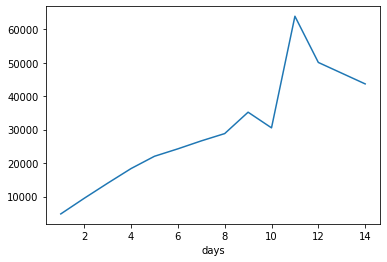

In [ ]:
eda.groupby(by='days').mean().sort_values('days')['Per Person Price'].plot()

In [ ]:
eda.loc[eda['days'] == 14].mean()

Flight Stops            0.666667
Meals                   4.333333
Per Person Price    43669.333333
days                   14.000000
dtype: float64

In [ ]:
ssp = eda[['Sightseeing Places Covered']]

In [ ]:
ssp.value_counts()

Sightseeing Places Covered                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Not Available                                                                                                                                                                                                                                                                                                                      

In [ ]:
all_places = set()

for i, row in ssp.iterrows():
    # print(row[0])
    for p in row[0].split(' | '):
        all_places.add(p.strip())

In [ ]:
len(all_places)

1143

In [ ]:
def f1(s):
    for x in s:
        if 
        return len()

In [ ]:
eda['no_of_ssp'] = eda['Sightseeing Places Covered'].apply(lambda x: -1 if x == 'Not Available' else len(x.split(' | ')))

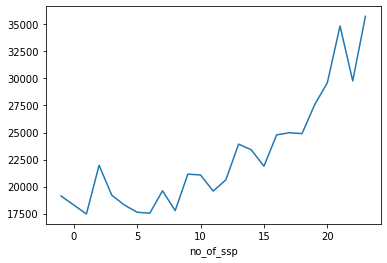

In [ ]:
eda.groupby('no_of_ssp').mean()['Per Person Price'].plot()

In [ ]:
al = eda[['Airline']]

In [ ]:
airlines = set()

for i, row in al.iterrows():
    # print(row[0])
    for p in row[0].split('|'):
        airlines.add(p.strip())

In [ ]:
airlines

{'Aeroflot',
 'Air Austral',
 'Air Baltic',
 'Air India',
 'Air India Express',
 'Air Mauritius',
 'Air New Zealand',
 'Air Seychelles',
 'AirAsia',
 'AirAsia Indonesia',
 'AirAsia X',
 'Airconnect',
 'Bangkok Airways',
 'British Airways',
 'Brussels Airlines',
 'Cathay Pacific',
 'China Eastern',
 'China Southern',
 'EgyptAir',
 'Emirates',
 'Ethiopian Airlines',
 'Etihad Airways',
 'Finnair',
 'Garuda Indonesia',
 'Go Air',
 'Gulf Air',
 'IndiGo',
 'Jetstar Airways',
 'Jetstar Asia',
 'Kenya Airways',
 'Kuwait Airways',
 'Lufthansa',
 'Malaysia Airlines',
 'Malindo Air',
 'Norwegian',
 'Not Available',
 'Oman Air',
 'Philippine Airlines',
 'Qantas Airways',
 'Qatar Airways',
 'Saudia',
 'Scoot',
 'Sichuan Airlines',
 'Silkair',
 'Singapore Airlines',
 'South African Airways',
 'Spicejet',
 'Srilankan Airlines',
 'Swiss',
 'Thai AirAsia',
 'Thai Airways',
 'Thai Vietjet Air',
 'Turkish Airlines',
 'Uzbekistan Airways',
 'Virgin Atlantic',
 'Vistara'}

In [ ]:
len(airlines)

56

# preprocess

In [ ]:
drop_cols = ['Uniq Id', 'Package Name', 'Destination']

train = raw_train.drop(drop_cols, axis=1)
test = raw_test.drop(drop_cols, axis=1)

train.head()

,Package Type,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,Standard,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,Premium,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,Luxury,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5
3,Premium,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0
4,Premium,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0


In [ ]:
mask = test['Places Covered'] == '30-01-2021'
test.loc[mask, 'Places Covered'] = 'Jaipur|Jodhpur|Jaisalmer|Bikaner|Jaipur'

## no of countries

In [ ]:
cities_df = pd.read_csv('/content/drive/MyDrive/workation_price_prediction/cities.csv', usecols=['Cities', 'is_foriegn', 'country'])
cities_df.head()

,Cities,is_foriegn,country
0,Abu Dhabi,1,uae
1,Agra,0,india
2,Ahmedabad,0,india
3,Ahmednagar,0,india
4,Ajmer,0,india


In [ ]:
city_country_map = { row['Cities']: row['country'] for i, row in cities_df.iterrows() }
# city_country_map

In [ ]:
def get_no_of_countries(x):
    countries = set()
    for c in x.split('|'):
        countries.add(city_country_map[c])

    return len(countries)

In [ ]:
train['no_of_countries'] = train['Places Covered'].apply(lambda x: get_no_of_countries(x))
test['no_of_countries'] = test['Places Covered'].apply(lambda x: get_no_of_countries(x))

In [ ]:
test.groupby('no_of_countries').agg(['count', 'mean'])

Flight Stops           Meals          
                       count      mean count      mean
no_of_countries                                       
1                       8718  0.871989  8718  3.670108
2                        269  1.163569   269  3.371747
3                         13  1.076923    13  3.769231

In [ ]:
train.head()

,Package Type,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,no_of_countries
0,Standard,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,1
1,Premium,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,1
2,Luxury,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,1
3,Premium,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,1
4,Premium,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,1


## country

In [ ]:
def get_country(x):
    countries = set()
    for c in x.split('|'):
        countries.add(city_country_map[c])

    return '_'.join(sorted(list(countries)))

In [ ]:
test['Places Covered'].apply(lambda x: get_country(x)).value_counts()

india                           7968
sri lanka                        199
uae                              165
england_sri lanka                107
thailand                          99
indonesia                         91
malaysia                          61
singapore                         57
indonesia_singapore               55
bhutan                            34
indonesia_malaysia                33
malaysia_singapore                22
india_thailand                    21
mauritius                         19
france                            14
england_india_sri lanka            9
singapore_thailand                 9
new zealand                        7
malaysia_thailand                  7
indonesia_malaysia_singapore       4
mauritius_seychelles               4
czech republic                     3
new zealand_singapore              3
india_malaysia                     3
hong kong_singapore                2
australia_singapore                2
denmark_russia                     1
r

In [ ]:
train['Places Covered'].apply(lambda x: get_country(x)).value_counts()

india                           18498
sri lanka                         435
uae                               363
england_sri lanka                 247
indonesia                         246
thailand                          223
malaysia                          196
indonesia_singapore               133
singapore                         115
indonesia_malaysia                109
bhutan                            100
india_thailand                     76
malaysia_singapore                 57
france                             41
england_india_sri lanka            30
mauritius                          20
singapore_thailand                 16
new zealand                        16
india_malaysia                     15
new zealand_singapore              15
indonesia_malaysia_singapore        9
australia_singapore                 7
malaysia_thailand                   7
mauritius_seychelles                6
denmark_russia                      5
czech republic                      5
russia      

In [ ]:
train['country'] = train['Places Covered'].apply(lambda x: get_country(x))
test['country'] = test['Places Covered'].apply(lambda x: get_country(x))

In [ ]:
train.head()

,Package Type,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,no_of_countries,country
0,Standard,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,1,india
1,Premium,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,1,india
2,Luxury,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,1,india
3,Premium,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,1,india
4,Premium,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,1,thailand


## is_foreign

In [ ]:
foreign = joblib.load('/content/drive/MyDrive/workation_price_prediction/foreign_cities')

In [ ]:
train['is_foreign'] = train['Places Covered'].apply(lambda x: int(any(c in foreign for c in x.split('|'))))
test['is_foreign'] = test['Places Covered'].apply(lambda x: int(any(c in foreign for c in x.split('|'))))

In [ ]:
train.head()

,Package Type,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign
0,Standard,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,1,india,0
1,Premium,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,1,india,0
2,Luxury,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,1,india,0
3,Premium,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,1,india,0
4,Premium,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,1,thailand,1


## hotel details

In [ ]:
ratings = joblib.load('/content/drive/MyDrive/workation_price_prediction/hotel_ratings')

def get_rating(row):
    if row == 'Not Available':
        return -1

    tot_rating, no_of_hotels = 0, 0
    for name_rat in row.split('|'):
        name, *_ = name_rat.split(':')
        tot_rating += ratings.get(name, 3.0)
        no_of_hotels += 1

    return tot_rating / no_of_hotels

def get_hotels(row):
    if row == 'Not Available':
        return -1

    no_of_hotels = 0
    for name_rat in row.split('|'):
        name, *_ = name_rat.split(':')
        no_of_hotels += 1

    return no_of_hotels

In [ ]:
train['avg_rating'] = train['Hotel Details'].apply(lambda x: get_rating(x))
train['no_of_hotels'] = train['Hotel Details'].apply(lambda x: -1 if x == 'Not Available' else len(x.split('|')))

train = train.drop('Hotel Details', axis=1)

train.head()

,Package Type,Itinerary,Places Covered,Travel Date,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels
0,Standard,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0,1,india,0,-1.000000,-1
1,Premium,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5,1,india,0,4.433333,3
2,Luxury,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5,1,india,0,4.200000,2
3,Premium,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0,1,india,0,4.550000,4
4,Premium,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0,1,thailand,1,4.350000,2


In [ ]:
test['avg_rating'] = test['Hotel Details'].apply(lambda x: get_rating(x))
test['no_of_hotels'] = test['Hotel Details'].apply(lambda x: -1 if x == 'Not Available' else len(x.split('|')))

test = test.drop('Hotel Details', axis=1)

## sight seeing places

In [ ]:
train['no_of_ssp'] = train['Sightseeing Places Covered'].apply(lambda x: -1 if x == 'Not Available' else len(x.split(' | ')))
test['no_of_ssp'] = test['Sightseeing Places Covered'].apply(lambda x: -1 if x == 'Not Available' else len(x.split(' | ')))

train = train.drop('Sightseeing Places Covered', axis=1)
test = test.drop('Sightseeing Places Covered', axis=1)

train.head()

,Package Type,Itinerary,Places Covered,Travel Date,Start City,Airline,Flight Stops,Meals,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp
0,Standard,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Mumbai,Not Available,2,3,Not Available,11509.0,1,india,0,-1.000000,-1,-1
1,Premium,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,New Delhi,IndiGo|IndiGo,0,5,Cancellation any time after making the 1st pay...,22485.5,1,india,0,4.433333,3,7
2,Luxury,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,New Delhi,IndiGo,0,4,Cancellation any time after making the 1st pay...,12421.5,1,india,0,4.200000,2,8
3,Premium,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,New Delhi,IndiGo,0,5,Cancellation any time after making the 1st pay...,35967.0,1,india,0,4.550000,4,9
4,Premium,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,New Delhi,Spicejet|Go Air,0,5,Cancellation any time after making the 1st pay...,25584.0,1,thailand,1,4.350000,2,2


## places covered

In [ ]:
train['no_of_places'] = train['Places Covered'].apply(lambda x: -1 if x == 'Not Available' else len(x.split('|')))
test['no_of_places'] = test['Places Covered'].apply(lambda x: -1 if x == 'Not Available' else len(x.split('|')))

train = train.drop('Places Covered', axis=1)
test = test.drop('Places Covered', axis=1)

train.head()

,Package Type,Itinerary,Travel Date,Start City,Airline,Flight Stops,Meals,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places
0,Standard,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,30-07-2021,Mumbai,Not Available,2,3,Not Available,11509.0,1,india,0,-1.000000,-1,-1,4
1,Premium,1N Srinagar . 2N Pahalgam . 1N Srinagar,08-12-2021,New Delhi,IndiGo|IndiGo,0,5,Cancellation any time after making the 1st pay...,22485.5,1,india,0,4.433333,3,7,3
2,Luxury,2N Udaipur . 1N Chittorgarh,26-04-2021,New Delhi,IndiGo,0,4,Cancellation any time after making the 1st pay...,12421.5,1,india,0,4.200000,2,8,2
3,Premium,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,27-08-2021,New Delhi,IndiGo,0,5,Cancellation any time after making the 1st pay...,35967.0,1,india,0,4.550000,4,9,4
4,Premium,4N Pattaya . 3N Bangkok,12-12-2021,New Delhi,Spicejet|Go Air,0,5,Cancellation any time after making the 1st pay...,25584.0,1,thailand,1,4.350000,2,2,2


              Flight Stops     Meals  ...  no_of_hotels  no_of_ssp
no_of_places                          ...                         
1                 0.863323  3.644415  ...      0.624837   3.546150
2                 0.888035  3.648162  ...      1.568455   7.281695
3                 0.859479  3.688050  ...      2.540521   9.253549
4                 0.857270  3.684211  ...      3.459114   9.698186
5                 0.860820  3.720686  ...      4.234509   9.067684
6                 1.022599  3.502825  ...      5.209040  10.203390
7                 1.029412  3.558824  ...      7.000000   9.901961
8                 1.416667  3.000000  ...      8.000000  14.583333
9                 1.129032  3.709677  ...      8.677419  13.967742
11                0.666667  4.333333  ...      9.000000   9.000000

[10 rows x 8 columns]


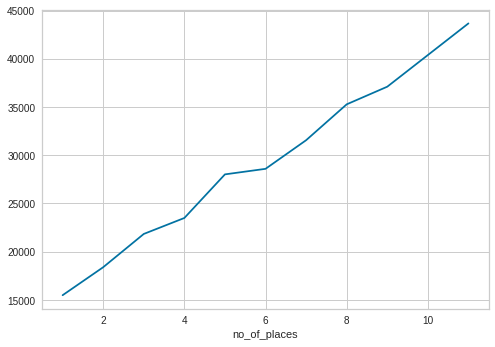

In [ ]:
print(train.groupby('no_of_places').mean())
train.groupby('no_of_places').mean()['Per Person Price'].plot()

## itinerary

In [ ]:
def get_nights(x):
    total_nights = 0
    for day_city in x.split(' . '):
        days = day_city.split()[0][:-1]
        total_nights += int(days)
    # print(total_nights)
    return total_nights

get_nights(train['Itinerary'].values[0])

6

In [ ]:
train['total_nights'] = train['Itinerary'].apply(lambda x: get_nights(x))
test['total_nights'] = test['Itinerary'].apply(lambda x: get_nights(x))

train = train.drop('Itinerary', axis=1)
test = test.drop('Itinerary', axis=1)

train.head()

,Package Type,Travel Date,Start City,Airline,Flight Stops,Meals,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights
0,Standard,30-07-2021,Mumbai,Not Available,2,3,Not Available,11509.0,1,india,0,-1.000000,-1,-1,4,6
1,Premium,08-12-2021,New Delhi,IndiGo|IndiGo,0,5,Cancellation any time after making the 1st pay...,22485.5,1,india,0,4.433333,3,7,3,4
2,Luxury,26-04-2021,New Delhi,IndiGo,0,4,Cancellation any time after making the 1st pay...,12421.5,1,india,0,4.200000,2,8,2,3
3,Premium,27-08-2021,New Delhi,IndiGo,0,5,Cancellation any time after making the 1st pay...,35967.0,1,india,0,4.550000,4,9,4,6
4,Premium,12-12-2021,New Delhi,Spicejet|Go Air,0,5,Cancellation any time after making the 1st pay...,25584.0,1,thailand,1,4.350000,2,2,2,7


## airline

In [ ]:
train['no_of_flights'] = train['Airline'].apply(lambda x: -1 if x == 'Not Available' else len(x.split('|')))
test['no_of_flights'] = test['Airline'].apply(lambda x: -1 if x == 'Not Available' else len(x.split('|')))

train = train.drop('Airline', axis=1)
test = test.drop('Airline', axis=1)

train.head()

,Package Type,Travel Date,Start City,Flight Stops,Meals,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights
0,Standard,30-07-2021,Mumbai,2,3,Not Available,11509.0,1,india,0,-1.000000,-1,-1,4,6,-1
1,Premium,08-12-2021,New Delhi,0,5,Cancellation any time after making the 1st pay...,22485.5,1,india,0,4.433333,3,7,3,4,2
2,Luxury,26-04-2021,New Delhi,0,4,Cancellation any time after making the 1st pay...,12421.5,1,india,0,4.200000,2,8,2,3,1
3,Premium,27-08-2021,New Delhi,0,5,Cancellation any time after making the 1st pay...,35967.0,1,india,0,4.550000,4,9,4,6,1
4,Premium,12-12-2021,New Delhi,0,5,Cancellation any time after making the 1st pay...,25584.0,1,thailand,1,4.350000,2,2,2,7,2


In [ ]:
train['no_of_flights'].value_counts()

 1     10008
-1      4910
 2      4283
 4      1267
 3       397
 5        82
 6        42
 10        3
 9         3
 8         2
 7         2
 11        1
Name: no_of_flights, dtype: int64

In [ ]:
test['no_of_flights'].value_counts()

 1    4283
-1    2100
 2    1852
 4     516
 3     201
 5      35
 6      11
 7       2
Name: no_of_flights, dtype: int64

## cancellation rules

In [ ]:
rule_map = {
    'Not Available': 'Rule_Type_1',
    'Cancellation any time after making the 1st payment instalment till the 2nd payment date:The entire amount paid as 1st payment instalment (deposit) would be non-refundable.Cancellation after 2nd payment instalment and before 3rd or final payment date:The total amount that was due at the 2nd payment instalment as per your payment schedule would be non-refundable; anything that you have paid over and above this amount would be refundable.Cancellation after 3rd or final payment date:The full amount paid by you would be non-refundable.': 'Rule_Type_2',
    'This cancellation policy is applicable for bookings made for Weekend Getaways through the MakeMyTrip platform   If the booking is made 15 days prior to the travel date (i.e. the date on which the customer is travelling):  When the customer has booked a weekend getaway 15 days (inclusive of the travel date) prior to the travel date, the customer is eligible to avail the benefit of this offer.At the time of making the payment while booking the package, the customer shall have the option of either paying in total or in instalments. If the customer chooses to make the payment in total and cancels the booking within 24 hours of making the payment, the customer shall be entitled to get the full refund under this offer. In case of any flight bookings, MakeMyTrip shall, in its sole discretion, refund partial booking amount to the customer. Full refund under the offer is not applicable on Air Asia, Scoot Airlines, Nok-Scoot and Tiger Australia.  If a customer chooses to make the payment in instalments and cancels the booking thereafter, MakeMyTrip shall provide the refund in the following manner:When the customer has made 1st instalment of the booking amount and the booking is cancelled within 24 hours of making the booking, MakeMyTrip shall refund the full amount paid in the 1st instalment. However, In case of any flight bookings, MakeMyTrip shall, in its sole discretion, refund partial booking amount to the customer. Full refund under the offer is not applicable on Air Asia, Scoot Airlines, Nok-Scoot & Tiger Australia.  When the customer has made 1st instalment of the booking amount and the booking is cancelled after 24 hours of making the booking but before making the 2nd instalment, the entire 1st instalment shall be non-refundable.  When the customer cancels the booking upon paying the 2nd instalment but before paying the 3rd instalment, the amount of 1st and 2nd instalment as paid by the customer shall be non-refundable. However, if the customer has paid an amount over and above the amount to be paid for the 1st and 2nd instalment, MakeMyTrip shall refund the said amount.  When the customer cancels the booking upon paying the 3rd instalment, the entire booking amount paid shall be non-refundable.  If the booking is made within 15 days from the travel date:   When the customer has made 1st instalment of the booking amount and the booking is cancelled before making the 2nd instalment, the entire 1st instalment shall be non-refundable.  When the customer cancels the booking upon paying the 2nd instalment but before paying the 3rd instalment, the amount of 1st and 2nd instalment as paid by the customer shall be non-refundable. However, if the customer has paid an amount over and above the amount to be paid for the 1st and 2nd instalment, MakeMyTrip shall refund the said amount.When the customer cancels the booking upon paying the 3rd instalment, the entire booking amount paid shall be non-refundable.': 'Rule_Type_3',
    "Price of the booking is calculated for per passenger on a twin-sharing basis. Prices are dynamic and may be based on offers running at the time of booking. MMT reserves the right to change prices at any time.Pricing of the booking is based on the age of the passengers. Please make sure you enter the correct age of passengers at the time of booking. Passengers furnishing incorrect age details may incur penalty at the time of travelling.A surcharge may be applicable for certain departures. In case the selected hotel is unavailable for booking, an alternate arrangement will be offered to the customer in another hotel of a similar category.Due to operational reasons, the routing of this tour may be amended. However, all mentioned services will remain unchanged.Cost of deviation and cost of extension of the validity on your ticket is not included.Porter fee at hotels, airports and seaports is not included in the package and has to be borne by the customer.Cost of expenses of personal nature such as, laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included.Any other items not mentioned under ?Inclusions? are not included in the cost of the booking.Package price does not include Gala dinner charges applicable on Christmas and New Year's Eve": 'Rule_Type_3',
    "GENERAL Please note that once your booking is confirmed, you will receive an e-mail as well as an SMS on your registered mobile number confirming your booking. However, if you would like to get in touch with us please call us on 0124-4859749. We are open from 8:00 am – 8:00 pm, seven days a week Please expect to receive your vouchers 72 hours before your departure date (subject to full payment of your package cost) Please note that these packages are customizable, which means that you will be able to make changes to the itinerary/activity if you so desire. The final payment will be calculated as per the activities reflecting on the website which will be outlined in the confirmatory e-mail sent to youPersonal expenses such as laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included In case your package needs to be cancelled due to any natural calamity, weather conditions etc. MakeMyTrip shall strive to give you the maximum possible refund subject to the agreement made with our trade partners/vendorsIf payment is not made as per the schedule provided in the first booking confirmation e-mail, MakeMyTrip reserves the right to cancel the booking after attempting to get in touch with you. Refunds would be as per the package cancellation policyFLIGHTSThe passenger names in the booking form should be exactly as per passports. MakeMyTrip will not bear any liability for the name change fee, if incorrect names and ages have been added at the time of bookingPlease note that if your package includes a flight which is a low cost carrier (Air Asia, Scoot Airlines, Air Arabia, Jetstar, Fly Dubai, Thai AirAsia, Air India Express, Tiger Airways) then baggage will not be included in the package. Baggage can be added as per your requirement at an additional cost depending on the airlines and destination. Our Travel Expert will attempt to get in touch with you within 24-hours after the booking has been confirmed for baggage additionPlease ensure that baggage requirements are given to our Travel Expert latest by 5 days before the date of departureHOTEL Standard check-in time at the hotel is normally 2:00 pm and check-out is 11:00 am. An early check-in, or a late check-out is solely based on the discretion of the hotelIn case the selected hotel is unavailable for booking, an alternate arrangement will be offered to the customer in another hotel of a similar categoryCertain hotels abroad may ask for a security deposit during check-in, which is refundable at check-out subject to the hotel’s policy\xa0\xa0SIGHTSEEING ACTIVITIES/TRANSFERSPlease note that 'Day at Leisure' essentially implies that no sightseeing activities have been included for that day Kindly be on time for your activities, tours and transfers. Most countries are quite strict about following a schedule": 'Rule_Type_2',
    'If your flights involve a combination of different airlines, you may have to collect your luggage on arrival at the connecting hub and register it again while checking in for the onward journey to your destination.Booking rates are subject to change without prior notice.Pricing of the booking is based on the age of the passengers. Please make sure you enter the correct age of passengers at the time of booking. Passengers furnishing incorrect age details may incur penalty at the time of travelling.Airline seats and hotel rooms are subject to availability at the time of booking.In case of unavailability in the listed hotels, arrangement for an alternate accommodation will be made in a hotel of similar standard.A maximum of 3 adults are allowed in one room. The third occupant shall be provided a mattress/rollaway bed.The itinerary is fixed and cannot be modified. Transportation shall be provided as per the itinerary and will not be at disposal. All transfers and sightseeing shall be provided by an exclusive vehicle unless otherwise specified.Due to operational reasons, the routing of this tour may be amended. However, all mentioned services will remain unchanged.MMT reserves the right to modify the itinerary at any point, due to reasons including but not limited to: Force Majeure events, strikes, fairs, festivals, weather conditions, traffic problems, overbooking of hotels / flights, cancellation / re-routing of flights, closure of / entry restrictions at a place of visit, etc. While we will do our best to make suitable alternate arrangements, we would not be held liable for any refunds/compensation claims arising out of this.The booking price does not include: -Expenses of personal nature, such as laundry, telephone calls, room service, alcoholic beverages, mini bar charges, tips, portage, camera fees etc.-Any meals and services not specifically mentioned in the inclusions. -Any other items not mentioned under ?Inclusions? are not included in the cost of the booking.Cost of deviation and cost of extension of the validity on your ticket is not included.For queries regarding cancellations and refunds, please refer to our Cancellation Policy.Disputes, if any, shall be subject to the exclusive jurisdiction of the courts in New Delhi.': 'Rule_Type_2',
    "If your flights involve a combination of different airlines, you may have to collect your luggage on arrival at the connecting hub and register it again while checking in for the onward journey to your destination.Booking rates are subject to change without prior notice.Pricing of the booking is based on the age of the passengers. Please make sure you enter the correct age of passengers at the time of booking. Passengers furnishing incorrect age details may incur penalty at the time of travelling.Airline seats and hotel rooms are subject to availability at the time of booking.In case of unavailability in the listed hotels, arrangement for an alternate accommodation will be made in a hotel of similar standard.A maximum of 3 adults are allowed in one room. The third occupant shall be provided a mattress/rollaway bed.The itinerary is fixed and cannot be modified. Transportation shall be provided as per the itinerary and will not be at disposal. All transfers and sightseeing shall be provided by an exclusive vehicle unless otherwise specified.Due to operational reasons, the routing of this tour may be amended. However, all mentioned services will remain unchanged.MMT reserves the right to modify the itinerary at any point, due to reasons including but not limited to: Force Majeure events, strikes, fairs, festivals, weather conditions, traffic problems, overbooking of hotels / flights, cancellation / re-routing of flights, closure of / entry restrictions at a place of visit, etc. While we will do our best to make suitable alternate arrangements, we would not be held liable for any refunds/compensation claims arising out of this.The booking price does not include: -Expenses of personal nature, such as laundry, telephone calls, room service, alcoholic beverages, mini bar charges, tips, portage, camera fees etc.-Any meals and services not specifically mentioned in the inclusions. -Any other items not mentioned under ?Inclusions? are not included in the cost of the booking.Cost of deviation and cost of extension of the validity on your ticket is not included.For queries regarding cancellations and refunds, please refer to our Cancellation Policy.Disputes, if any, shall be subject to the exclusive jurisdiction of the courts in New Delhi.Package price does not include Gala dinner charges applicable on Christmas and New Year's Eve": 'Rule_Type_3',
    "Package price does not include Gala dinner charges applicable on Christmas and New Year's Eve": 'Rule_Type_3',
    'Packages will be escorted by Local Representative of the Vendor on the day of Full or Half day tours as per itinerary.Vendor Representative are English speaking &\xa0 Explain about the Tours in English Language Only. Package has the flexibility to add extra Nights before start of the Tour and at the end of the tour. Please contact MMT representative.Package has the flexibility to add extra Optional tours within the itinerary subject to time availability in each Package. Please contact MMT representative.Price of the Holiday Services are calculated per passenger on twin-sharing basis.The taxes mentioned are taxes as applicable on September 1st, 2017. In the event of increase in the rate of taxation, the differential amount will be payable by the customer. A surcharge may be applicable for certain departures.Service tax charges will apply, as applicable.Cost of deviation and cost of extension of the validity on your ticket is not included.Porter fees at hotels, airports and seaports is not included in the Holiday Services and has to be borne by the customer.Cost of expenses of personal nature such as, laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included.Any other items not mentioned in the Inclusions list are not included in the cost of the Holiday Services.Prices are dynamic and based on offers running at the time of booking. MMT reserves the right to change prices at any time.In case the selected hotel is unavailable for booking, an alternate arrangement will be offered to the customer in a hotel of similar category.Due to operational reasons, the routing of this holiday may be amended. However, all mentioned services will remain unchanged.Pricing of the Holiday Services is based on the age of the passengers. Please make sure you enter it correctly at the time of booking. Furnishing wrong passenger age may incur penalty at a later stage.': 'Rule_Type_3',
    'GENERAL Please note that once your booking is confirmed, you will receive an e-mail as well as an SMS on your registered mobile number confirming your booking. However, if you would like to get in touch with us please call us on 0124-4859749. We are open from 8:00 am o?= 8:00 pm, seven days a week Please expect to receive your vouchers 72 hours before your departure date (subject to full payment of your package cost) Please note that these packages are customizable, which means that you will be able to make changes to the itinerary/activity if you so desire. The final payment will be calculated as per the activities reflecting on the website which will be outlined in the confirmatory e-mail sent to youPersonal expenses such as laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included In case your package needs to be cancelled due to any natural calamity, weather conditions etc. MakeMyTrip shall strive to give you the maximum possible refund subject to the agreement made with our trade partners/vendorsIf payment is not made as per the schedule provided in the first booking confirmation e-mail, MakeMyTrip reserves the right to cancel the booking after attempting to get in touch with you. Refunds would be as per the package cancellation policyFLIGHTSThe passenger names in the booking form should be exactly as per passports. MakeMyTrip will not bear any liability for the name change fee, if incorrect names and ages have been added at the time of bookingPlease note that if your package includes a flight which is a low cost carrier (Air Asia, Scoot Airlines, Air Arabia, Jetstar, Fly Dubai, Thai AirAsia, Air India Express, Tiger Airways) then baggage will not be included in the package. Baggage can be added as per your requirement at an additional cost depending on the airlines and destination. Our Travel Expert will attempt to get in touch with you within 24-hours after the booking has been confirmed for baggage additionPlease ensure that baggage requirements are given to our Travel Expert latest by 5 days before the date of departureHOTEL Standard check-in time at the hotel is normally 2:00 pm and check-out is 11:00 am. An early check-in, or a late check-out is solely based on the discretion of the hotelIn case the selected hotel is unavailable for booking, an alternate arrangement will be offered to the customer in another hotel of a similar categoryCertain hotels abroad may ask for a security deposit during check-in, which is refundable at check-out subject to the hotelo?=s policy\xa0\xa0SIGHTSEEING ACTIVITIES/TRANSFERSPlease note that Day at Leisure essentially implies that no sightseeing activities have been included for that day Kindly be on time for your activities, tours and transfers. Most countries are quite strict about following a schedule': 'Rule_Type_2'
}

In [ ]:
train['Cancellation Rules'] = train['Cancellation Rules'].map(rule_map)
test['Cancellation Rules'] = test['Cancellation Rules'].map(rule_map) 

In [ ]:
train['Cancellation Rules'].value_counts()

Rule_Type_2    17578
Rule_Type_3     2627
Rule_Type_1      795
Name: Cancellation Rules, dtype: int64

In [ ]:
test['Cancellation Rules'].value_counts()

Rule_Type_2    7493
Rule_Type_3    1160
Rule_Type_1     347
Name: Cancellation Rules, dtype: int64

In [ ]:
train.head()

,Package Type,Travel Date,Start City,Flight Stops,Meals,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights
0,Standard,30-07-2021,Mumbai,2,3,Rule_Type_1,11509.0,1,india,0,-1.000000,-1,-1,4,6,-1
1,Premium,08-12-2021,New Delhi,0,5,Rule_Type_2,22485.5,1,india,0,4.433333,3,7,3,4,2
2,Luxury,26-04-2021,New Delhi,0,4,Rule_Type_2,12421.5,1,india,0,4.200000,2,8,2,3,1
3,Premium,27-08-2021,New Delhi,0,5,Rule_Type_2,35967.0,1,india,0,4.550000,4,9,4,6,1
4,Premium,12-12-2021,New Delhi,0,5,Rule_Type_2,25584.0,1,thailand,1,4.350000,2,2,2,7,2


## not available values

In [ ]:
train = train.replace(-1, np.nan)
test = test.replace(-1, np.nan)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Package Type        21000 non-null  object 
 1   Travel Date         21000 non-null  object 
 2   Start City          21000 non-null  object 
 3   Flight Stops        21000 non-null  int64  
 4   Meals               21000 non-null  int64  
 5   Cancellation Rules  21000 non-null  object 
 6   Per Person Price    21000 non-null  float64
 7   is_foreign          21000 non-null  int64  
 8   avg_rating          18071 non-null  float64
 9   no_of_hotels        18071 non-null  float64
 10  no_of_ssp           19377 non-null  float64
 11  no_of_places        21000 non-null  int64  
 12  total_nights        21000 non-null  int64  
 13  no_of_flights       16090 non-null  float64
dtypes: float64(5), int64(5), object(4)
memory usage: 2.2+ MB


In [ ]:
train['avg_rating'] = train['avg_rating'].fillna(train['avg_rating'].median())
train['no_of_hotels'] = train['no_of_hotels'].fillna(method='bfill')
train['no_of_ssp'] = train['no_of_ssp'].fillna(train['no_of_ssp'].median())
train['no_of_flights'] = train['no_of_flights'].fillna(method='bfill')

In [ ]:
test['avg_rating'] = test['avg_rating'].fillna(test['avg_rating'].median())
test['no_of_hotels'] = test['no_of_hotels'].fillna(method='bfill')
test['no_of_ssp'] = test['no_of_ssp'].fillna(test['no_of_ssp'].median())
test['no_of_flights'] = test['no_of_flights'].fillna(method='bfill')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Package Type        21000 non-null  object 
 1   Travel Date         21000 non-null  object 
 2   Start City          21000 non-null  object 
 3   Flight Stops        21000 non-null  int64  
 4   Meals               21000 non-null  int64  
 5   Cancellation Rules  21000 non-null  object 
 6   Per Person Price    21000 non-null  float64
 7   is_foreign          21000 non-null  int64  
 8   avg_rating          21000 non-null  float64
 9   no_of_hotels        21000 non-null  int64  
 10  no_of_ssp           21000 non-null  int64  
 11  no_of_places        21000 non-null  int64  
 12  total_nights        21000 non-null  int64  
 13  no_of_flights       21000 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Package Type        9000 non-null   object 
 1   Travel Date         9000 non-null   object 
 2   Start City          9000 non-null   object 
 3   Flight Stops        9000 non-null   int64  
 4   Meals               9000 non-null   int64  
 5   Cancellation Rules  9000 non-null   object 
 6   is_foreign          9000 non-null   int64  
 7   avg_rating          9000 non-null   float64
 8   no_of_hotels        9000 non-null   float64
 9   no_of_ssp           9000 non-null   float64
 10  no_of_places        9000 non-null   int64  
 11  total_nights        9000 non-null   int64  
 12  no_of_flights       9000 non-null   float64
dtypes: float64(4), int64(5), object(4)
memory usage: 914.2+ KB


## travel date

In [ ]:
# train['year'] = pd.to_datetime(train['Travel Date'], dayfirst=True).dt.year
# dates = pd.to_datetime(train['Travel Date'], dayfirst=True)
months = pd.to_datetime(train['Travel Date'], dayfirst=True).dt.month
# train['is_vacation'] = (months.isin([4, 5])).astype(int)
train['is_april'] = (months == 4).astype(int)
# train['month'] = months
# train['day_diff'] = (dates - datetime(2020, 12, 31)).dt.days
# train['weekday'] = pd.to_datetime(train['Travel Date'], dayfirst=True).dt.weekday
# train['date'] = pd.to_datetime(train['Travel Date'], dayfirst=True).dt.date

train = train.drop('Travel Date', axis=1)

In [ ]:
train.head()

,Package Type,Start City,Flight Stops,Meals,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights,is_april
0,Standard,Mumbai,2,3,Rule_Type_1,11509.0,1,india,0,-1.000000,-1,-1,4,6,-1,0
1,Premium,New Delhi,0,5,Rule_Type_2,22485.5,1,india,0,4.433333,3,7,3,4,2,0
2,Luxury,New Delhi,0,4,Rule_Type_2,12421.5,1,india,0,4.200000,2,8,2,3,1,1
3,Premium,New Delhi,0,5,Rule_Type_2,35967.0,1,india,0,4.550000,4,9,4,6,1,0
4,Premium,New Delhi,0,5,Rule_Type_2,25584.0,1,thailand,1,4.350000,2,2,2,7,2,0


In [ ]:
# test['year'] = pd.to_datetime(test['Travel Date'], dayfirst=True).dt.year
# dates = pd.to_datetime(test['Travel Date'], dayfirst=True)
months = pd.to_datetime(test['Travel Date'], dayfirst=True).dt.month
# test['is_vacation'] = (months.isin([4, 5])).astype(int)
test['is_april'] = (months == 4).astype(int)
# test['month'] = months
# test['day_diff'] = (dates - datetime(2020, 12, 31)).dt.days
# test['weekday'] = pd.to_datetime(test['Travel Date'], dayfirst=True).dt.weekday
# test['date'] = pd.to_datetime(test['Travel Date'], dayfirst=True).dt.date

test = test.drop('Travel Date', axis=1)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Package Type        21000 non-null  object 
 1   Start City          21000 non-null  object 
 2   Flight Stops        21000 non-null  int64  
 3   Meals               21000 non-null  int64  
 4   Cancellation Rules  21000 non-null  object 
 5   Per Person Price    21000 non-null  float64
 6   no_of_countries     21000 non-null  int64  
 7   country             21000 non-null  object 
 8   is_foreign          21000 non-null  int64  
 9   avg_rating          21000 non-null  float64
 10  no_of_hotels        21000 non-null  int64  
 11  no_of_ssp           21000 non-null  int64  
 12  no_of_places        21000 non-null  int64  
 13  total_nights        21000 non-null  int64  
 14  no_of_flights       21000 non-null  int64  
 15  is_april            21000 non-null  int64  
dtypes: f

In [ ]:
# sw.compare([train, 'Train Data'], [test, 'Test Data'], target_feat='Per Person Price').show_notebook()

## feature engineering

In [ ]:
train['ssp_per_night'] = train['no_of_ssp'] / train['total_nights']
# train['hotels_per_places'] = train['no_of_hotels'] / train['no_of_places']
# train['meals_per_flight_stops'] = train['Meals'] / (1 + train['Flight Stops'])
train['places_per_night'] = train['no_of_places'] / train['total_nights']

In [ ]:
test['ssp_per_night'] = test['no_of_ssp'] / test['total_nights']
# test['hotels_per_places'] = test['no_of_hotels'] / test['no_of_places']
# test['meals_per_flight_stops'] = test['Meals'] / (1 + test['Flight Stops'])
test['places_per_night'] = test['no_of_places'] / test['total_nights']

In [ ]:
train.head()

,Package Type,Start City,Flight Stops,Meals,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights,is_april,ssp_per_night,places_per_night
0,Standard,Mumbai,2,3,Rule_Type_1,11509.0,1,india,0,-1.000000,-1,-1,4,6,-1,0,-0.166667,0.666667
1,Premium,New Delhi,0,5,Rule_Type_2,22485.5,1,india,0,4.433333,3,7,3,4,2,0,1.750000,0.750000
2,Luxury,New Delhi,0,4,Rule_Type_2,12421.5,1,india,0,4.200000,2,8,2,3,1,1,2.666667,0.666667
3,Premium,New Delhi,0,5,Rule_Type_2,35967.0,1,india,0,4.550000,4,9,4,6,1,0,1.500000,0.666667
4,Premium,New Delhi,0,5,Rule_Type_2,25584.0,1,thailand,1,4.350000,2,2,2,7,2,0,0.285714,0.285714


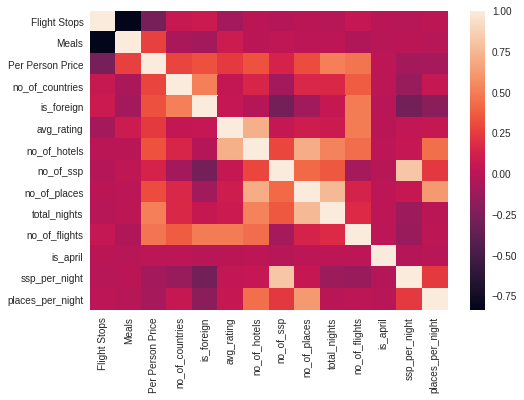

In [ ]:
sns.heatmap(train.corr())

In [ ]:
train.to_csv('/content/drive/MyDrive/workation_price_prediction/clean_train3.csv', index=False)

In [ ]:
test.to_csv('/content/drive/MyDrive/workation_price_prediction/clean_test3.csv', index=False)

## transformations

# pycaret

In [ ]:
from pycaret.regression import *

In [ ]:
train.columns

Index(['Package Type', 'Start City', 'Flight Stops', 'Meals',
       'Cancellation Rules', 'Per Person Price', 'no_of_countries', 'country',
       'is_foreign', 'avg_rating', 'no_of_hotels', 'no_of_ssp', 'no_of_places',
       'total_nights', 'no_of_flights', 'is_april', 'ssp_per_night',
       'places_per_night'],
      dtype='object')

In [ ]:
# pycaret_data = scaled_data.copy()
pycaret_data = train.copy()
# pycaret_data = pd.read_csv('/content/drive/MyDrive/workation_price_prediction/clean_train2.csv')
pycaret_data.head()

,Package Type,Start City,Flight Stops,Meals,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights,is_april,ssp_per_night,places_per_night
0,Standard,Mumbai,2,3,Rule_Type_1,11509.0,1,india,0,-1.000000,-1,-1,4,6,-1,0,-0.166667,0.666667
1,Premium,New Delhi,0,5,Rule_Type_2,22485.5,1,india,0,4.433333,3,7,3,4,2,0,1.750000,0.750000
2,Luxury,New Delhi,0,4,Rule_Type_2,12421.5,1,india,0,4.200000,2,8,2,3,1,1,2.666667,0.666667
3,Premium,New Delhi,0,5,Rule_Type_2,35967.0,1,india,0,4.550000,4,9,4,6,1,0,1.500000,0.666667
4,Premium,New Delhi,0,5,Rule_Type_2,25584.0,1,thailand,1,4.350000,2,2,2,7,2,0,0.285714,0.285714


In [ ]:
pycaret_test_data = test.copy()
# pycaret_test_data = pd.read_csv('/content/drive/MyDrive/workation_price_prediction/clean_test2.csv')
pycaret_test_data.head()

,Package Type,Start City,Flight Stops,Meals,Cancellation Rules,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights,is_april,ssp_per_night,places_per_night
0,Luxury,New Delhi,0,4,Rule_Type_2,1,india,0,4.10,1,-1,1,5,1,0,-0.200000,0.200000
1,Luxury,New Delhi,0,4,Rule_Type_3,1,india,0,4.40,1,1,1,2,-1,0,0.500000,0.500000
2,Standard,New Delhi,2,3,Rule_Type_3,1,india,0,-1.00,-1,4,1,3,-1,0,1.333333,0.333333
3,Deluxe,Mumbai,1,3,Rule_Type_3,1,india,0,-1.00,-1,6,1,3,-1,0,2.000000,0.333333
4,Luxury,New Delhi,0,4,Rule_Type_2,1,india,0,4.55,4,10,4,5,1,0,2.000000,0.800000


In [ ]:
ig_feats = ['Flight Stops', 'ssp_per_night']
ord_feats = {
    'Start City': ['New Delhi', 'Mumbai'],
}
num_feats = ['no_of_places', 'total_nights', 'no_of_hotels', 'no_of_ssp', 'no_of_countries', 'Meals', 'Flight Stops']


reg_problem = setup(
    data=pycaret_data,
    target='Per Person Price',
    ignore_features=ig_feats,
    numeric_features=num_feats,
    ordinal_features=ord_feats,
    normalize=True,
    transform_target=True,
    # remove_outliers=True,
    # polynomial_features=True,
    # polynomial_degree=3,
    # trigonometry_features=True
    # feature_interaction=True,
    # feature_selection=True,
    # remove_multicollinearity=True,
    # use_gpu=True,
    session_id=1234
)

,Description,Value
0,session_id,1234
1,Target,Per Person Price
2,Original Data,"(21000, 18)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,7
6,Ordinal Features,True
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(14699, 60)"


In [ ]:
lgb = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3912.2732,5.020257e+07,7085.3770,0.6943,0.2487,0.1876
1,3956.0287,4.666332e+07,6831.0554,0.6519,0.2558,0.1842
2,3830.7074,3.529487e+07,5940.9482,0.7347,0.2517,0.1929
3,3730.3693,4.197596e+07,6478.8858,0.7328,0.2440,0.1850
4,3817.3458,3.565571e+07,5971.2399,0.7201,0.2480,0.1947
5,3703.5359,3.971359e+07,6301.8719,0.7061,0.2457,0.1811
6,3537.6159,3.298530e+07,5743.2833,0.6955,0.2397,0.1805
7,3943.6337,6.452644e+07,8032.8348,0.6436,0.2498,0.1837
8,3510.3996,2.808626e+07,5299.6473,0.7587,0.2446,0.1859
9,3596.2762,3.339217e+07,5778.5956,0.7443,0.2374,0.1853


In [ ]:
rfc = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3204.4631,2.772058e+07,5265.0336,0.7337,0.2282,0.1687
1,3249.8955,3.255894e+07,5706.0441,0.7151,0.2404,0.1694
2,3495.7405,4.572708e+07,6762.1801,0.6483,0.2434,0.1772
3,3328.2375,3.351023e+07,5788.8018,0.6910,0.2313,0.1644
4,3222.5682,2.699673e+07,5195.8380,0.7386,0.2323,0.1674
5,3389.6413,3.251071e+07,5701.8162,0.6793,0.2429,0.1747
6,3171.4021,2.359440e+07,4857.4065,0.7685,0.2248,0.1652
7,3419.6310,3.794410e+07,6159.8782,0.7104,0.2439,0.1757
8,3494.2671,3.706452e+07,6088.0641,0.6589,0.2350,0.1736
9,3435.1757,3.522094e+07,5934.7229,0.7005,0.2471,0.1752


In [ ]:
cat = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3657.4201,3.472664e+07,5892.9313,0.6925,0.2395,0.1813
1,3769.3025,4.024018e+07,6343.5150,0.7126,0.2424,0.1851
2,3622.8607,3.585533e+07,5987.9323,0.7053,0.2316,0.1771
3,3669.4983,3.760675e+07,6132.4341,0.7132,0.2365,0.1766
4,3731.8705,3.877559e+07,6227.0050,0.6743,0.2519,0.1848
5,3843.5053,4.993151e+07,7066.2228,0.6296,0.2429,0.1849
6,3443.6234,2.986811e+07,5465.1721,0.7315,0.2334,0.1740
7,3551.2217,3.201725e+07,5658.3792,0.7145,0.2349,0.1775
8,3498.4034,3.166879e+07,5627.5031,0.7458,0.2362,0.1768
9,3538.0145,4.436037e+07,6660.3580,0.6571,0.2401,0.1758


In [ ]:
xgb = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3561.4956,3.395549e+07,5827.1343,0.6994,0.2341,0.1766
1,3571.8650,3.615127e+07,6012.5923,0.7418,0.2341,0.1777
2,3575.1150,3.523179e+07,5935.6377,0.7104,0.2289,0.1745
3,3571.7825,3.666015e+07,6054.7622,0.7204,0.2320,0.1731
4,3614.9131,3.684592e+07,6070.0840,0.6905,0.2461,0.1791
5,3640.6526,4.774944e+07,6910.0972,0.6458,0.2371,0.1775
6,3347.3044,2.899632e+07,5384.8237,0.7394,0.2295,0.1688
7,3391.6218,2.924738e+07,5408.0850,0.7392,0.2271,0.1702
8,3477.5891,3.031536e+07,5505.9385,0.7566,0.2336,0.1744
9,3460.3215,4.040556e+07,6356.5366,0.6877,0.2357,0.1734


In [ ]:
best_model = compare_models(sort='RMSLE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,3293.7979,3.418833e+07,5812.1877,0.7538,0.2311,0.1658,5.322
lightgbm,Light Gradient Boosting Machine,3746.4987,4.064794e+07,6331.5426,0.7096,0.2454,0.1854,0.287
et,Extra Trees Regressor,3478.2658,3.915408e+07,6222.2055,0.7148,0.2482,0.1761,4.659
gbr,Gradient Boosting Regressor,4154.8292,4.702031e+07,6816.1688,0.6632,0.2689,0.2078,1.804
dt,Decision Tree Regressor,3893.0123,5.095654e+07,7099.7544,0.6290,0.2792,0.1973,0.139
knn,K Neighbors Regressor,4156.7420,5.042691e+07,7070.8053,0.6371,0.2798,0.2055,0.869
ridge,Ridge Regression,4640.6512,5.413312e+07,7325.5726,0.6083,0.2970,0.2337,0.065
br,Bayesian Ridge,4640.8250,5.414259e+07,7326.2034,0.6083,0.2970,0.2337,0.126
huber,Huber Regressor,4610.2412,5.644864e+07,7473.4368,0.5934,0.2989,0.2271,0.737
omp,Orthogonal Matching Pursuit,5000.3267,6.768795e+07,8188.7565,0.5137,0.3151,0.2479,0.072


In [ ]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

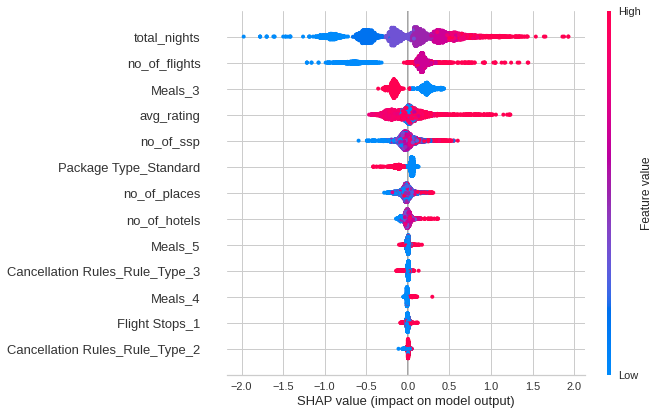

In [ ]:
interpret_model(cat)

In [ ]:
tuned_cat = tune_model(cat)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4043.5807,4.424809e+07,6651.9242,0.6476,0.2631,0.2015
1,4305.3209,6.087965e+07,7802.5415,0.5703,0.2730,0.2029
2,4251.4569,5.697576e+07,7548.2290,0.5974,0.2692,0.2052
3,4135.5376,4.729693e+07,6877.2762,0.6221,0.2655,0.2070
4,4142.3101,4.427691e+07,6654.0900,0.6382,0.2581,0.1959
5,3995.3777,3.738333e+07,6114.1908,0.6656,0.2589,0.2038
6,4213.2497,4.708016e+07,6861.4986,0.6381,0.2716,0.2063
7,4028.3278,4.325588e+07,6576.9206,0.6317,0.2670,0.2072
8,4277.2282,5.396180e+07,7345.8698,0.5916,0.2668,0.2044
9,4085.1424,4.219585e+07,6495.8334,0.6364,0.2679,0.2037


In [ ]:
tuned_lgb = tune_model(lgb, search_library='scikit-optimize')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4068.9860,4.360774e+07,6603.6160,0.6139,0.2653,0.2027
1,4243.9517,5.483703e+07,7405.2029,0.6084,0.2656,0.2052
2,3991.6216,4.586247e+07,6772.1839,0.6230,0.2541,0.1939
3,4109.2314,5.123255e+07,7157.6918,0.6093,0.2614,0.1957
4,4150.1413,4.560327e+07,6753.0193,0.6170,0.2694,0.2040
5,4205.2887,5.843353e+07,7644.1826,0.5666,0.2634,0.2040
6,3861.2237,3.853105e+07,6207.3383,0.6537,0.2544,0.1944
7,3862.6696,3.782356e+07,6150.0863,0.6628,0.2548,0.1948
8,3950.9790,4.356228e+07,6600.1729,0.6503,0.2556,0.1953
9,3881.4355,5.236749e+07,7236.5383,0.5952,0.2619,0.1933


In [ ]:
blended_models = blend_models([xgb, rfc, cat], optimize='RMSLE', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3524.5214,3.516505e+07,5930.0127,0.7219,0.2300,0.1728
1,3456.2463,3.458415e+07,5880.8291,0.7267,0.2251,0.1684
2,3565.8877,4.234037e+07,6506.9475,0.6664,0.2372,0.1738
3,3367.2975,3.053662e+07,5525.9946,0.7266,0.2279,0.1684
4,3350.7246,3.488262e+07,5906.1509,0.7255,0.2288,0.1670
Mean,3452.9355,3.550176e+07,5949.9870,0.7134,0.2298,0.1701
SD,84.4685,3.814653e+06,315.3024,0.0236,0.0040,0.0027


In [ ]:
ens_xgb = ensemble_model(xgb, method='Bagging', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3646.0129,3.552251e+07,5960.0762,0.7191,0.2363,0.1829
1,3605.7888,3.410737e+07,5840.1519,0.7305,0.2338,0.1827
2,3772.5513,4.212891e+07,6490.6787,0.6680,0.2470,0.1902
3,3574.6951,3.226607e+07,5680.3232,0.7111,0.2393,0.1823
4,3541.8962,3.620499e+07,6017.0581,0.7151,0.2344,0.1798
Mean,3628.1889,3.604597e+07,5997.6576,0.7088,0.2382,0.1836
SD,79.9599,3.327079e+06,272.1646,0.0214,0.0048,0.0035


In [ ]:
ensembled_rfc = ensemble_model(best_model, method='Boosting', fold=5, optimize='RMSLE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3488.4373,3.902080e+07,6246.6634,0.7384,0.2380,0.1694
1,3493.0400,3.580640e+07,5983.8450,0.7532,0.2399,0.1786
2,3454.7136,3.563826e+07,5969.7786,0.7285,0.2400,0.1759
3,3377.3553,4.083236e+07,6390.0204,0.7181,0.2366,0.1719
4,3201.4357,2.622573e+07,5121.1059,0.7876,0.2291,0.1696
Mean,3402.9964,3.550471e+07,5942.2827,0.7451,0.2367,0.1731
SD,108.9650,5.038952e+06,440.4387,0.0242,0.0040,0.0036


In [ ]:
 stacked_models = stack_models([rfc, rfc], Ridge(), optimize='RMSLE', fold=4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3559.4171,3.942238e+07,6278.7241,0.7347,0.2396,0.1719
1,3409.9834,3.227117e+07,5680.7719,0.7657,0.2339,0.1743
2,3428.2292,4.249147e+07,6518.5479,0.6935,0.2332,0.1688
3,3260.0631,2.753115e+07,5247.0132,0.7883,0.2241,0.1692
Mean,3414.4232,3.542904e+07,5931.2643,0.7455,0.2327,0.1711
SD,106.1374,5.877361e+06,499.1434,0.0356,0.0056,0.0022


In [ ]:
final_model = finalize_model(blended_models)

In [ ]:
preds = predict_model(final_model, data=pycaret_test_data)
preds

,Package Type,Start City,Flight Stops,Meals,Cancellation Rules,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights,ssp_per_night,hotels_per_places,meals_per_flight_stops,places_per_night,Label
0,Luxury,New Delhi,0,4,Rule_Type_2,0,4.100000,1,-1,1,5,1,-0.200000,1.0,4.000000,0.200000,17515.611825
1,Luxury,New Delhi,0,4,Rule_Type_3,0,4.400000,1,1,1,2,-1,0.500000,1.0,4.000000,0.500000,9790.622576
2,Standard,New Delhi,2,3,Rule_Type_3,0,-1.000000,-1,4,1,3,-1,1.333333,-1.0,1.000000,0.333333,5624.365100
3,Deluxe,Mumbai,1,3,Rule_Type_3,0,-1.000000,-1,6,1,3,-1,2.000000,-1.0,1.500000,0.333333,8992.877712
4,Luxury,New Delhi,0,4,Rule_Type_2,0,4.550000,4,10,4,5,1,2.000000,1.0,4.000000,0.800000,19752.358606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,Standard,New Delhi,2,3,Rule_Type_2,0,3.966667,3,10,3,4,1,2.500000,1.0,1.000000,0.750000,11334.948143
8996,Deluxe,Mumbai,1,3,Rule_Type_2,0,3.800000,4,12,4,4,1,3.000000,1.0,1.500000,1.000000,15117.218990
8997,Luxury,Mumbai,0,4,Rule_Type_2,0,4.250000,2,12,2,5,1,2.400000,1.0,4.000000,0.400000,22348.659730
8998,Deluxe,New Delhi,1,3,Rule_Type_2,0,4.125000,4,11,4,7,1,1.571429,1.0,1.500000,0.571429,22472.165059


In [ ]:
raw_sub['Per Person Price'] = preds['Label']
print(raw_sub.shape)
raw_sub.head()

(9000, 1)


,Per Person Price
0,17515.611825
1,9790.622576
2,5624.365100
3,8992.877712
4,19752.358606


In [ ]:
raw_sub.to_csv('blended_models_2298.csv', index=False)

# xgboost

In [ ]:
xgb_data = pd.read_csv('/content/drive/MyDrive/workation_price_prediction/clean_train3.csv')
xgb_test_data = pd.read_csv('/content/drive/MyDrive/workation_price_prediction/clean_test3.csv')

In [ ]:
xgb_data.head()

,Package Type,Start City,Flight Stops,Meals,Cancellation Rules,Per Person Price,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights,is_april,ssp_per_night,places_per_night
0,Standard,Mumbai,2,3,Rule_Type_1,11509.0,1,india,0,-1.000000,-1,-1,4,6,-1,0,-0.166667,0.666667
1,Premium,New Delhi,0,5,Rule_Type_2,22485.5,1,india,0,4.433333,3,7,3,4,2,0,1.750000,0.750000
2,Luxury,New Delhi,0,4,Rule_Type_2,12421.5,1,india,0,4.200000,2,8,2,3,1,1,2.666667,0.666667
3,Premium,New Delhi,0,5,Rule_Type_2,35967.0,1,india,0,4.550000,4,9,4,6,1,0,1.500000,0.666667
4,Premium,New Delhi,0,5,Rule_Type_2,25584.0,1,thailand,1,4.350000,2,2,2,7,2,0,0.285714,0.285714


In [ ]:
data = xgb_data.drop(['Per Person Price', 'is_april', 'Start City', 'ssp_per_night', 'places_per_night'], axis=1)
test_data = xgb_test_data.drop(['is_april', 'Start City', 'ssp_per_night', 'places_per_night'], axis=1)

target = xgb_data['Per Person Price']
log_target = np.log(target)

In [ ]:
num_features = ['no_of_hotels', 'no_of_ssp', 'no_of_places', 'total_nights', 'no_of_flights', 'no_of_countries']
data[num_features] = data[num_features].astype(float)
test_data[num_features] = test_data[num_features].astype(float)

In [ ]:
cat_cols = data.select_dtypes(include=['object', 'int']).columns
cat_cols

Index(['Package Type', 'Flight Stops', 'Meals', 'Cancellation Rules',
       'country', 'is_foreign'],
      dtype='object')

In [ ]:
for c in cat_cols:
    le = LabelEncoder()
    le.fit(data[c].unique().tolist() + test_data[c].unique().tolist())
    data[c] = le.transform(data[c])
    test_data[c] = le.transform(test_data[c])

In [ ]:
data.head()

,Package Type,Flight Stops,Meals,Cancellation Rules,no_of_countries,country,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights
0,4,2,1,0,1.0,10,0,-1.000000,-1.0,-1.0,4.0,6.0,-1.0
1,3,0,3,1,1.0,10,0,4.433333,3.0,7.0,3.0,4.0,2.0
2,2,0,2,1,1.0,10,0,4.200000,2.0,8.0,2.0,3.0,1.0
3,3,0,3,1,1.0,10,0,4.550000,4.0,9.0,4.0,6.0,1.0
4,3,0,3,1,1.0,28,1,4.350000,2.0,2.0,2.0,7.0,2.0


In [ ]:
te = ce.TargetEncoder(cols=cat_cols)
sc = StandardScaler()

In [ ]:
target.skew()

2.5601007661713506

In [ ]:
log_target.skew()

-0.23113227486283472

In [ ]:
transformed_data = te.fit_transform(data, log_target)
transformed_data

,Package Type,Flight Stops,Meals,Cancellation Rules,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights
0,9.571755,9.558286,9.635177,9.521680,-1.000000,9.377630,9.652945,9.991776,10.017673,9.326475
1,9.952420,9.951084,9.952420,9.849715,4.433333,9.929633,9.788908,9.896703,9.724030,9.876022
2,9.948808,9.951084,9.948808,9.849715,4.200000,9.750431,9.688585,9.694124,9.441274,9.876022
3,9.952420,9.951084,9.952420,9.849715,4.550000,10.011973,9.864118,9.991776,10.017673,9.876022
4,9.952420,9.951084,9.952420,9.849715,4.350000,9.750431,9.748751,9.694124,10.114048,9.962540
...,...,...,...,...,...,...,...,...,...,...
20995,9.695040,9.695040,9.635177,9.849715,4.066667,9.929633,9.843253,9.896703,10.017673,9.326475
20996,9.948808,9.951084,9.948808,9.849715,4.300000,10.011973,9.864118,9.991776,10.114048,9.876022
20997,9.695040,9.695040,9.635177,9.849715,4.000000,9.552246,9.748751,9.441183,9.910105,9.876022
20998,9.695040,9.695040,9.635177,9.849715,4.100000,9.929633,10.268259,9.896703,10.017673,9.876022


In [ ]:
scaled_data = pd.DataFrame(sc.fit_transform(transformed_data, log_target), columns=data.columns)
scaled_data.head()

,Package Type,Flight Stops,Meals,Cancellation Rules,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights
0,-1.121052,-1.213494,-0.778202,-1.198506,-2.436537,-1.614167,-0.744670,0.994421,0.753365,-1.729008
1,1.109166,1.113754,1.151670,0.429975,0.591424,0.697372,0.174448,0.580985,-0.115621,0.447154
2,1.088004,1.113754,1.129697,0.429975,0.461389,-0.053046,-0.503744,-0.299952,-0.952390,0.447154
3,1.109166,1.113754,1.151670,0.429975,0.656442,1.042176,0.682878,0.994421,0.753365,0.447154
4,1.109166,1.113754,1.151670,0.429975,0.544983,-0.053046,-0.097016,-0.299952,1.038570,0.789760


In [ ]:
# data = pd.get_dummies(data, columns=['Flight Stops', 'Meals', 'no_of_flights', 'Cancellation Rules', 'Package Type'])
# test_data = pd.get_dummies(test_data, columns=['Flight Stops', 'Meals', 'no_of_flights', 'Cancellation Rules', 'Package Type'])

In [ ]:
# data['Start City'] = data['Start City'].map({'New Delhi': 0, 'Mumbai': 1})
# test_data['Start City'] = test_data['Start City'].map({'New Delhi': 0, 'Mumbai': 1})

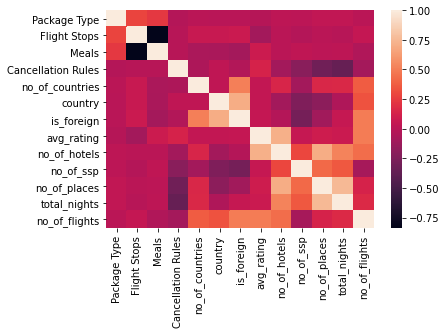

In [ ]:
sns.heatmap(data.corr())

In [ ]:
def objective(trial):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15, random_state=42)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        # 'tree_method':'gpu_hist',  # Use GPU acceleration
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_loguniform(
            'lambda', 1e-3, 10.0
        ),
        'alpha': trial.suggest_loguniform(
            'alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.6,0.7,0.8,1.0]
        ),
        'learning_rate': trial.suggest_categorical(
            'learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]
        ),
        'n_estimators': trial.suggest_categorical(
            "n_estimators", [150, 200, 300, 3000]
        ),
        'max_depth': trial.suggest_categorical(
            'max_depth', [4,5,7,9,11,13,15,17]
        ),
        'random_state': 42,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x, train_y, eval_set=[(test_x,test_y)], early_stopping_rounds=100, verbose=False)
    
    preds = np.abs(model.predict(test_x))
    
    rmsle = np.sqrt(mean_squared_log_error(test_y, preds))
    
    return rmsle

In [ ]:
%%time

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-04-08 11:52:06,855] A new study created in memory with name: no-name-3cc8987a-1dad-4c95-ba3d-0da4275620f4
[I 2021-04-08 11:52:10,868] Trial 0 finished with value: 0.24875637146514704 and parameters: {'lambda': 0.1728673166764528, 'alpha': 0.047952119951020895, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 200, 'max_depth': 11, 'min_child_weight': 45}. Best is trial 0 with value: 0.24875637146514704.
[I 2021-04-08 11:52:35,928] Trial 1 finished with value: 0.26316245108568065 and parameters: {'lambda': 0.005866658485802532, 'alpha': 0.0030692867718126876, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.014, 'n_estimators': 3000, 'max_depth': 4, 'min_child_weight': 130}. Best is trial 0 with value: 0.24875637146514704.
[I 2021-04-08 11:53:37,840] Trial 2 finished with value: 0.253215231036682 and parameters: {'lambda': 0.0012428290164222938, 'alpha': 0.46257883448116144, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate':

KeyboardInterrupt: ignored

False

In [ ]:
study.best_params

{'alpha': 1.5096175209928844,
 'colsample_bytree': 0.9,
 'lambda': 0.32192525737481154,
 'learning_rate': 0.016,
 'max_depth': 17,
 'min_child_weight': 1,
 'n_estimators': 3000,
 'subsample': 0.7}

In [ ]:
study.best_params

{'alpha': 0.20552884249275855,
 'colsample_bytree': 0.5,
 'lambda': 0.024640424786569224,
 'learning_rate': 0.016,
 'max_depth': 13,
 'min_child_weight': 5,
 'n_estimators': 300,
 'subsample': 0.8}

In [ ]:
BEST_PARAMS = { 'objective': 'reg:squarederror' }
BEST_PARAMS.update(**study.best_params)
BEST_PARAMS

{'alpha': 1.5096175209928844,
 'colsample_bytree': 0.9,
 'lambda': 0.32192525737481154,
 'learning_rate': 0.016,
 'max_depth': 17,
 'min_child_weight': 1,
 'n_estimators': 3000,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [ ]:
scores = cross_val_score(xgb.XGBRegressor(**BEST_PARAMS), data, target, scoring='neg_mean_squared_log_error')

In [ ]:
print(np.sqrt(np.abs(scores)))
np.sqrt(np.abs(scores)).mean()

[0.23283852 0.23165872 0.22142574 0.22783921 0.24273216]


0.23129887148329842

In [ ]:
final_model = xgb.XGBRegressor(**BEST_PARAMS)

In [ ]:
final_model.fit(data, target)

XGBRegressor(alpha=1.5096175209928844, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', lambda=0.32192525737481154,
             learning_rate=0.016, max_delta_step=0, max_depth=17,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=1.50961757, reg_lambda=0.321925253, scale_pos_weight=1,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [ ]:
preds = final_model.predict(test_data)

In [ ]:
preds.shape

(9000,)

(array([4.267e+03, 3.831e+03, 7.300e+02, 1.160e+02, 3.000e+01, 1.100e+01,
        8.000e+00, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([  1813.2787,  17275.04  ,  32736.799 ,  48198.56  ,  63660.316 ,
         79122.08  ,  94583.836 , 110045.59  , 125507.36  , 140969.11  ,
        156430.88  ], dtype=float32),
 <a list of 10 Patch objects>)

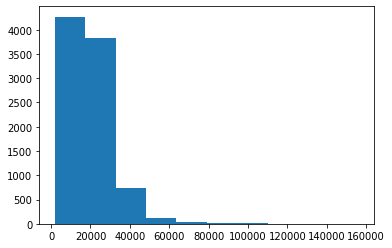

In [ ]:
plt.hist(preds)

In [ ]:
sub = pd.DataFrame(
    { 'Per Person Price': preds }
)
sub.head()

,Per Person Price
0,16978.736328
1,11442.150391
2,5517.643066
3,8698.987305
4,19194.582031


In [ ]:
sub.to_csv('xgboost_1.csv', index=False)

In [ ]:
dtrain = xgb.DMatrix(filt_df, label=labels)

In [ ]:
param = {
    'max_depth': 7, 
    'eta': 0.008, 
    'eval_metric': ['merror'], 
    'num_class': 5
}

In [ ]:
model = xgb.XGBClassifier(**param)

In [ ]:
xgb.cv(
    params=param,
    dtrain=dtrain,
    nfold=6,
)

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.335405,0.000909,0.384313,0.008163
1,0.334015,0.001686,0.383086,0.006879
2,0.333508,0.001799,0.382760,0.006790
3,0.333426,0.001827,0.382023,0.007585
4,0.332674,0.001759,0.382514,0.006056
5,0.332707,0.001633,0.382268,0.006632
6,0.332477,0.001633,0.381614,0.006401
7,0.331954,0.001931,0.381206,0.007111
8,0.332019,0.002138,0.380960,0.006408
9,0.331316,0.001971,0.380878,0.007062


In [ ]:
oof_preds = cross_val_predict(model, filt_df, labels)

In [ ]:
print(f"f1 Score: {f1_score(labels, oof_preds, average='weighted'):.4f}")
print(f"accuracy: {accuracy_score(labels, oof_preds):.4f}")
print(f'Total Bid: {total_bidding(labels, oof_preds)}')
print(f'Profit: {get_profit(labels, oof_preds)}')


f1 Score: 0.6218
accuracy: 0.6249
Total Bid: 22937
Profit: 18257


In [ ]:
# total bid : 30470
# profit: 30470

# random forest

In [ ]:
data = train.drop('Per Person Price', axis=1)
target = train['Per Person Price']

log_target = np.log(target)

In [ ]:
data.head()

,Package Type,Start City,Flight Stops,Meals,Cancellation Rules,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights
0,Standard,Mumbai,2,3,Rule_Type_1,0,-1.000000,-1,-1,4,6,-1
1,Premium,New Delhi,0,5,Rule_Type_2,0,4.433333,3,7,3,4,1
2,Luxury,New Delhi,0,4,Rule_Type_2,0,4.200000,2,8,2,3,1
3,Premium,New Delhi,0,5,Rule_Type_2,0,4.550000,4,9,4,6,1
4,Premium,New Delhi,0,5,Rule_Type_2,1,4.350000,2,2,2,7,2


In [ ]:
cat_cols = data.select_dtypes(include=['object', 'int']).columns
cat_cols

Index(['Package Type', 'Start City', 'Flight Stops', 'Meals',
       'Cancellation Rules', 'is_foreign', 'no_of_hotels', 'no_of_ssp',
       'no_of_places', 'total_nights', 'no_of_flights'],
      dtype='object')

In [ ]:
te = ce.TargetEncoder(cols=cat_cols)
sc = StandardScaler()

In [ ]:
transformed_data = te.fit_transform(data, log_target)
transformed_data

,Package Type,Start City,Flight Stops,Meals,Cancellation Rules,is_foreign,avg_rating,no_of_hotels,no_of_ssp,no_of_places,total_nights,no_of_flights
0,9.571755,9.805340,9.558286,9.635177,9.521680,9.704132,-1.000000,9.377630,9.652945,9.991776,10.017673,9.326475
1,9.952420,9.740751,9.951084,9.952420,9.849715,9.704132,4.433333,9.929633,9.788908,9.896703,9.724030,9.876022
2,9.948808,9.740751,9.951084,9.948808,9.849715,9.704132,4.200000,9.750431,9.688585,9.694124,9.441274,9.876022
3,9.952420,9.740751,9.951084,9.952420,9.849715,9.704132,4.550000,10.011973,9.864118,9.991776,10.017673,9.876022
4,9.952420,9.740751,9.951084,9.952420,9.849715,10.199081,4.350000,9.750431,9.748751,9.694124,10.114048,9.962540
...,...,...,...,...,...,...,...,...,...,...,...,...
20995,9.695040,9.805340,9.695040,9.635177,9.849715,9.704132,4.066667,9.929633,9.843253,9.896703,10.017673,9.326475
20996,9.948808,9.740751,9.951084,9.948808,9.849715,9.704132,4.300000,10.011973,9.864118,9.991776,10.114048,9.876022
20997,9.695040,9.740751,9.695040,9.635177,9.849715,10.199081,4.000000,9.552246,9.748751,9.441183,9.910105,9.876022
20998,9.695040,9.740751,9.695040,9.635177,9.849715,9.704132,4.100000,9.929633,10.268259,9.896703,10.017673,9.876022


In [ ]:
rfc = RandomForestRegressor()

In [ ]:
scores = cross_val_score(rfc, transformed_data, log_target, cv=10, scoring='neg_mean_squared_log_error')

In [ ]:
rfc.fit(transformed_data, log_target)

# blend submission

In [ ]:
sub1 = pd.read_csv('/content/blended_models_2298.csv')
sub2 = pd.read_csv('/content/blended_models_2317.csv')

In [ ]:
sub1.head()

,Per Person Price
0,17515.611825
1,9790.622576
2,5624.365100
3,8992.877712
4,19752.358606


In [ ]:
new_sub = sub1.copy()

In [ ]:
new_sub['Per Person Price'] = sub1['Per Person Price'] * 0.7 + sub2['Per Person Price'] * 0.3
new_sub

,Per Person Price
0,17369.239488
1,10244.386456
2,5667.400927
3,8768.403933
4,19748.089336
...,...
8995,11299.904593
8996,15082.704244
8997,21788.616653
8998,22281.700045


In [ ]:
new_sub.to_csv('new_sub.csv', index=False)